# Coherence functions, spectra and antibunching in molecular resonance fluorescence

In [1]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options, entropy_mutual
import qutip as qt
import numpy as np
from numpy import sqrt, pi
from utils import *
import phonons as RC
from style import *
import matplotlib.pyplot as plt
import optical as EM
import time
#from importlib import reload
import copy


G= basis(2,0)
E = basis(2,1)

sigma = G*E.dag()

I_sys = qeye(2)
initial_sys = G*G.dag()#0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.

utils imported


# Weak coupling phonons

In [2]:
reload(EM)

def weak_phonon(H_sub, alpha=0., w0=0., Gamma=0., T=0., tol=1e-5):
    A = sigma.dag()*sigma 
    
    return EM.L_non_rwa(H_sub, A, w0, Gamma, T, J_underdamped, 
                     principal=True, silent=True, alpha=alpha, tol=tol) # need principal value parts



In [3]:
def mutual_info(rho, selA=0, selB=1, base=2):
    return entropy_mutual(rho, selA, selB)

def current(rho, L, operator):
    return (qt.vector_to_operator(L*qt.operator_to_vector(rho))*operator).tr()


In [6]:
def WC_comparison(detuning=0., alpha=0.01, Rabi=0.01, w0=0.01, N=5, 
      T_ph=77., Gamma=0.01, overdamped_cutoff=0, tf=1., wc_tol=1e-5):
    
    epsilon = 1*ev_to_inv_cm
    detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*ev_to_inv_cm
    Gamma = Gamma*ev_to_inv_cm
    alpha_ph = alpha*ev_to_inv_cm
    
    if abs(overdamped_cutoff)>0:
        Gamma = (w0**2)/overdamped_cutoff
    Gamma_EM =  100*5.309e-3
    
    
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    shift = 0.5*pi*alpha_ph/2
    
    timelist = np.linspace(0, tf, int(tf*1300))
    energies, states = exciton_states(detuning, Rabi, shift=shift)
    
    real_exciton = 0.5*(states[1]*states[0].dag() + states[0]*states[1].dag())
    imag_exciton = 0.5*1j*(states[1]*states[0].dag() - states[0]*states[1].dag())
    J = J_minimal
    L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, Gamma, 
                                                                        w0, alpha_ph, N,
                                                                        silent=True, w_laser=w_laser)
    
    L = copy.deepcopy(L_RC)
    L_add = copy.deepcopy(L_RC)
    #assert L==L_add
    options = Options(nsteps=1500, store_states=True)
    
    n_RC = EM.Occupation(w0, T_ph)
    I = qeye(N)
    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
    expects = [tensor(G*G.dag(), I), tensor(E*E.dag(), I), tensor(E*G.dag()+G*E.dag(), I), #0, 1, 2
               Rabi*(1j*tensor(G*E.dag()-E*G.dag(), I)), # 3, TLS current
                tensor(real_exciton, I), tensor(imag_exciton, I), #4,5
               tensor(qeye(2), destroy(N).dag()*destroy(N)), # 6
               tensor(qeye(2), destroy(N).dag()+destroy(N)), # 7
               kappa*1j*tensor(E*E.dag(), destroy(N).dag()-destroy(N))] # 8
    L += EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    
    ss_sc = steadystate(H, [L])
    ss_expvals_sc = [(ss_sc*ex).tr() for ex in expects]
    dynamics_sc = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=expects, options=options)
    
    L_add += EM.L_nonsecular(tensor(H_sub, I), A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    
    ss_add = steadystate(H, [L_add])
    ss_expvals_add = [(ss_add*ex).tr() for ex in expects]
    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
    dynamics_add = mesolve(H, rho_0, timelist, c_ops=[L_add], e_ops=expects, options=options)
    
    expects = [G*G.dag(), E*E.dag(), E*G.dag()+G*E.dag(), #0, 1, 2
               1j*Rabi*(G*E.dag()-E*G.dag()), # 3, TLS current
               real_exciton, imag_exciton] # 4, 5
    
    #L_wc = wc.L_wc_analytic(detuning=detuning, Rabi=Rabi, alpha=alpha_ph, w0=w0, Gamma=Gamma, T=T_ph, tol=1e-5)
    
    L_wc = weak_phonon(H_sub, alpha=alpha_ph, 
                       w0=w0, Gamma=Gamma, T=T_ph, tol=wc_tol)
    
    L_wc+= EM.L_nonsecular(H_sub, sigma, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    
    H_sub_shift = H_sub + shift*E*E.dag()
    ss_wc = steadystate(H_sub_shift, [L_wc])
    ss_expvals_wc = [(ss_wc*ex).tr() for ex in expects]
    rho_0 = initial_sys
    dynamics_wc = mesolve(H_sub_shift, rho_0, timelist, c_ops=[L_wc], e_ops=expects, options=options)
            
    #print( "Full:\n", ss[0].ptrace(0).full(), '\n Add.:\n', ss[1].ptrace(0).full())
    print("Dynamics complete")
    scope = locals()
    PARAM_names = ['Rabi', 'kappa', 'gamma', 'Gamma_EM', 'Gamma', 'alpha_ph', 
                   'w0', 'H_sub', 'H_sub_shift', 'shift', 'detuning', 'overdamped_cutoff']
    
    PARAMS = {name: eval(name, scope) for name in PARAM_names}
    #print(PARAMS)
    timelist*=inv_ps_to_inv_cm # convert time from cm to ps : cm^-1/ps^-1 = ps/cm
    
    scope = locals()
    data_names = ['ss_expvals_sc', 'ss_sc', 'dynamics_sc', 'ss_expvals_add', 'ss_add', 'dynamics_add',
                  'ss_expvals_wc', 'ss_wc', 'dynamics_wc', 'L_RC', 'H', 'A_ph', 'timelist', 'PARAMS']
    
    return {name: eval(name, scope) for name in data_names}

In [7]:
def plot_wc_dynamics(data_dict, timelength=1):
    labels = ['Full', 'Redfield']
    linestyles = ['solid', 'solid']
    timelist = data_dict['timelist']
    alphas = [1, 0.5]
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12,12), sharex=True,tight_layout=True)
    for i, suff in enumerate(['_sc', '_wc']):
        dynamics = data_dict['dynamics'+suff]
        ss = data_dict['ss_expvals'+suff]
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        
        ax1.plot(timelist, dynamics.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax1.axhline(ss[1], color=c, ls='dotted')
        ax2.plot(timelist, dynamics.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax2.axhline(ss[2].real, color=c, ls='dotted')
        #ax3.plot(timelist, dynamics.expect[4].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        #ax3.axhline(ss[4].real, color=c, ls='dotted')
        ax3.plot(timelist, dynamics.expect[3].real, label=l, color=c, ls=linestyle, alpha=a) # TLS current
        ax3.axhline(ss[3].real, color=c, ls='dotted')
        
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    #ax3.set_ylabel(r'$  \langle -| \rho_S(t)|+\rangle |$')
    ax3.set_ylabel(r'$\langle I_{g \to e} \rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax3.set_xlabel('Time ($ps$)')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()
    

def plot_additive_dynamics(data_dict, timelength=1):
    labels = ['Full', 'Add.']
    linestyles = ['solid', 'dashed']
    timelist = data_dict['timelist']
    alphas = [1, 1]
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12,12), sharex=True,tight_layout=True)
    for i, suff in enumerate(['_sc', '_add']):
        dynamics = data_dict['dynamics'+suff]
        ss = data_dict['ss_expvals'+suff]
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        
        ax1.plot(timelist, dynamics.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax1.axhline(ss[1], color=c, ls='dotted')
        ax2.plot(timelist, dynamics.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax2.axhline(ss[2].real, color=c, ls='dotted')
        #ax3.plot(timelist, dynamics.expect[4].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        #ax3.axhline(ss[4].real, color=c, ls='dotted')
        ax3.plot(timelist, dynamics.expect[3].real, label=l, color=c, ls=linestyle, alpha=a) # TLS current
        ax3.axhline(ss[3].real, color=c, ls='dotted')
        
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    #ax3.set_ylabel(r'$  \langle -| \rho_S(t)|+\rangle |$')
    ax3.set_ylabel(r'$\langle I_{g \to e} \rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax3.set_xlabel('Time ($ps$)')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()

# Comparison to Weak coupling theory

Detunings are going to be $(1meV, 10meV)$.

Coupling strengths are going to be $(1meV, 10meV, 100meV)$.

Temperatures are $35, 77, 150K$

Mode frequencies are $6meV, 12meV, 18meV$ (or $48, 96, 145 cm^{-1}$)

# First order coherence function and emission spectra

# Second order coherence functions

In [16]:
def coherence_2nd_order_ss(H, tlist, c_ops, sigma, rho0=None):
    """
    Calculate the correlation function <sigma_dag(0)sigma_dag(tau)sigma(tau)sigma(0)>

    (ss_gtt = steadystate general two-time)
    
    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental. 
    """
    ti = time.time()
    if rho0 == None:
        rho0 = steadystate(H, c_ops)
    dat = mesolve(H, sigma * rho0 * sigma.dag(), tlist, c_ops, [sigma.dag() * sigma]).expect[0]
    print( "G2 took {:0.3f} seconds".format(time.time()-ti))
    return dat

In [17]:
method = 'adams'
order = 12
reload(EM)

def RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC, 
                steps_per_tau=500.,nsteps=4000, tau_f=2., label='Full'):
    # code which actually makes the emission spectrum data and g1
    options = qt.Options(nsteps=nsteps, store_states=True)
    E_op = sigma_RC.dag()*sigma_RC
    ti = time.time()
    dat = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[E_op], options=options)
    pop = dat.expect[0]
    P = dat.states
    
    print( "Completed initial dynamics calculations for {} in {}  seconds.".format(label, time.time()-ti))
    ti = time.time()
    Lambda_0 = sigma_RC*sum(P)
    del P, dat
    Lambda_t = mesolve(H, Lambda_0, taulist, [L], options=options, progress_bar=None)

    g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
    g_1/=abs(g_1[0])

    spec = sp.fftpack.fft(g_1)
    dt = taulist[1]-taulist[0]
    freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
    spec = 2 * dt* np.real(spec)
    #freq, spec = qt.spectrum_correlation_fft(taulist, g_1) # old method
    spec-= min(spec)
    spec = spec/sum(spec)
    freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))
    print( "Completed correlation function calculations for {} in {} seconds.".format(label, time.time()-ti))
    return pop, g_1, spec, freq

# Parameters

Detunings are going to be $(1meV, 10meV)$.

Coupling strengths are going to be $(1meV, 10meV, 100meV)$.

Temperatures are $35, 77, 150K$

Mode frequencies are $6meV, 12meV, 18meV$ (or $48, 96, 145 cm^{-1}$)


In [18]:
def weak_phonon(H_sub, alpha=0., w0=0., Gamma=0., T=0., tol=1e-5):
    A = sigma.dag()*sigma 
    
    return EM.L_non_rwa(H_sub, A, w0, Gamma, T, J_underdamped, 
                     principal=True, silent=True, alpha=alpha, tol=tol) # need principal value parts

def params_gamma(detuning=0., alpha=0.001, Rabi=1., w0=0.01, Gamma=20., T_ph=77., epsilon=1.4, overdamped=False):
    # Taken from how Steck defines things : in terms of Gamma_EM
    Gamma_EM =  1 #1*5.309e-3
    detuning = detuning*Gamma_EM #detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1000. #1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*Gamma_EM #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*Gamma_EM
    Gamma = 30.
    if overdamped:
        Gamma = (w0**2)/100.
    alpha = alpha*Gamma_EM
    print( "Alpha: {}, Rabi: {}, w_laser: {}, detuning: {}, Gamma: {}, w0: {}, Gamma_EM: {}".format(alpha, Rabi, w_laser, 
                                                                                detuning, Gamma, w0, Gamma_EM))
    PARAMS_names = ['Gamma_EM', 'detuning', 'epsilon', 'w_laser', 'Rabi', 'w0', 'Gamma', 'alpha', 'T_ph', 'N']
    scope = locals()
    return {name: eval(name, scope) for name in PARAMS_names}

def params_ev(detuning=0., alpha=10e-3, Rabi=1e-3, w0=12e-3, 
              Gamma=12e-3, T_ph=77., epsilon=1.4, Gamma_EM=66e-08,
              overdamped=False, N=7):
    w_laser = epsilon + detuning
    if overdamped:
        Gamma = (w0**2)/50e-3
    print( "Alpha: {}meV, Rabi: {}meV, w_laser: {}meV, detuning: {}meV, Gamma: {}meV, w0: {}meV, Gamma_EM: {}meV, N: {}".format(alpha, Rabi, w_laser, 
                                                                    detuning, Gamma, w0, Gamma_EM, N))
    PARAMS_names = ['Gamma_EM', 'detuning', 'epsilon', 'w_laser', 'Rabi', 'w0', 'Gamma', 'alpha']
    scope = locals()
    pars = {name: eval(name, scope)*ev_to_inv_cm for name in PARAMS_names}
    pars.update({'T_ph': T_ph, 'N': N})
    return pars

In [6]:
1*5.309e-3/ev_to_inv_cm

6.582356952451801e-07

In [7]:
RC.RC_mapping_general

<function phonons.RC_mapping_general>

In [12]:
  
    
def RF_data(PARAMS, t_f=4., steps_per_tau=500., steps_per_t=900, tau_f=2., overdamped=False, nsteps=3000):
    # collects all the data for plotting
    alpha = PARAMS['alpha']
    Gamma_EM = PARAMS['Gamma_EM']
    detuning = PARAMS['detuning']
    epsilon = PARAMS['epsilon']
    w_laser = PARAMS['w_laser']
    N = PARAMS['N']
    Rabi = PARAMS['Rabi']
    w0 = PARAMS['w0']
    Gamma = PARAMS['Gamma']
    T_ph = PARAMS['T_ph']
    
    J = J_minimal
    
    kappa= np.sqrt(np.pi * alpha * w0 / 2.)
    shift = 0.5*((kappa**2)/w0)
    #w_laser += shift
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print( "Driven Hamiltonian: \n", H_sub.full())
    n_RC = Occupation(w0, T_ph)
    
    if abs(alpha)>0:
        I = qeye(N)
        L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, Gamma, w0, 
                                                                          alpha, N, 
                                                                          silent=True, w_laser=w_laser)
        H_add = tensor(H_sub, I)
        E_op = tensor(E*E.dag(), I) # population operator
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        sigma_RC = tensor(sigma, I)
        
    else:
        L_RC, H, A_EM = 0, H_sub, sigma
        H_add = H_sub
        E_op = E*E.dag() # population operator
        rho_0 = initial_sys
        sigma_RC = sigma
    
    labels = ['Full', 'Naive']
    L_full = EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    #L_add =  EM.L_nonsecular(H_add, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    L_EM_list = [L_full]
    #final_t = end_T_mult/Gamma_EM
    #print "final t: ", final_t
    #timelist = np.linspace(0, final_t, int(T_increments*final_t))
    timelist = np.linspace(0, t_f, t_f*steps_per_t)
    taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
    pop_list = []
    g1_data = []
    spectrum_data = []
    freq_data = []
    g2_data = []
    for i, L_EM in enumerate(L_EM_list):
        L = L_RC + L_EM
        ss = steadystate(H, [L])
        print( "Steadystate: \n", ss.ptrace(0).full())
        pop, g1, spec, freq = RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC,
                                      nsteps=nsteps, tau_f=tau_f, label=labels[i])
        g2 = coherence_2nd_order_ss(H, timelist, [L], sigma_RC, rho0=ss)
        pop_list.append(pop)
        g1_data.append(g1)
        spectrum_data.append(spec)
        freq_data.append(freq)
        norm_den = ((ss*sigma_RC.dag()*sigma_RC).tr()**2).real
        g2_data.append(g2/norm_den)
    
    L_wc = weak_phonon(H_sub, alpha=alpha, 
                       w0=w0, Gamma=Gamma, T=T_ph, tol=1e-5)
    
    L_wc+= EM.L_nonsecular(H_sub, sigma, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    
    H_sub_shift = H_sub + shift*E*E.dag()
    
    rho_0 = initial_sys
    ss = steadystate(H_sub_shift, [L_wc])
    pop, g1, spec, freq = RF_spectrum(H_sub_shift, rho_0, timelist, taulist, L_wc, sigma,
                                  nsteps=nsteps, tau_f=tau_f, label='Redfield')
    g2 = coherence_2nd_order_ss(H_sub_shift, timelist, [L_wc], sigma, rho0=ss)
    pop_list.append(pop)
    g1_data.append(g1)
    spectrum_data.append(spec)
    freq_data.append(freq)
    norm_den = ((ss*sigma.dag()*sigma).tr()**2).real
    g2_data.append(g2/norm_den)
    timelist*= inv_ps_to_inv_cm
    taulist *= inv_ps_to_inv_cm
    print( "All spectra calculated.")
    PARAM_names = ['timelist', 'pop_list', 'taulist', 'g1_data', 'spectrum_data', 'freq_data', 'g2_data']
    scope = locals()
    data_dict = {name: eval(name, scope) for name in PARAM_names}
    
    return data_dict

In [9]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [10]:
def plot_spectra(data_dict, freq_window=1000., tau_window=False, dyn_window_div = 7., plot_name=None):
    pallete = ['#DC143C', '#4682B4'][::-1]
    plt.close('all')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
    timelist = data_dict['timelist']
    taulist = data_dict['taulist']
    #f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    #f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    label = ['CCME', 'Redfield']
    ls = ['solid', 'dashed']
    freq = data_dict['freq_data']
    # 'timelist', 'pop_list', 'taulist', 'g1_data', 'spectrum_data', 'freq_data', 'g2_data'
    for i, spec in enumerate(data_dict['spectrum_data']):
        g_1  = data_dict['g1_data'][i]
        g_2  = data_dict['g2_data'][i]
        freq = data_dict['freq_data'][i]
        ax1.plot(timelist, data_dict['pop_list'][i],label=label[i], linestyle=ls[i], c=pallete[i])
        ax3.plot(taulist, g_1.real, label=label[i], linestyle=ls[i], c=pallete[i])
        ax4.plot(timelist, g_2, label=label[i], linestyle=ls[i], c=pallete[i])
        ax2.plot(freq, spec, label=label[i], linestyle=ls[i], c=pallete[i])
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    if tau_window:
        ax3.set_xlim(0,tau_window)
    else:
        ax3.set_xlim(0,taulist[-1])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    ax4.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax1.set_xlabel(r"Time (ps)")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    ax2.set_ylim(0,max(data_dict['spectrum_data'][1]))
    if freq_window is not None:
        if type(freq_window) in [float, int]:
            ax2.set_xlim(-freq_window,freq_window)
        else:
            print (freq_window)
            ax2.set_xlim(freq_window[0],freq_window[1])
    ax1.set_ylabel(r"$\langle\sigma^{\dagger}\sigma \rangle $")
    ax2.set_ylabel(r"$S(\omega)$ (arb. units)")
    ax3.set_ylabel(r"$g^{(1)}(\tau)$") # coherence
    #ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$g^{(2)}_{ss}(\tau)$") # coherence
    ax3.set_xlabel(r"$\tau$ (ps)")
    #ax4.set_xlabel(r"$\tau$") # if lower right is imag part of g1
    ax4.set_xlabel(r"$\tau$ (ps)")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=None)
    #ax1.legend()
    ax2.legend()
    ax3.legend()
    #ax4.legend()
    if plot_name is not None:
        name = "figures/"+plot_name+'.pdf'
        plt.savefig(name)
        print("Plot saved at "+ name)
    plt.show()
    

In [115]:

PARAMS = params_ev(detuning=0.1e-3, alpha=10e-3, Rabi=1e-3, w0=40e-3, 
              Gamma=12e-3, T_ph=77., epsilon=1.4, Gamma_EM=7e-07,
              overdamped=False, N=11)

data_dict_1 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)


Alpha: 0.01meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.012meV, w0: 0.04meV, Gamma_EM: 7e-07meV, N: 11
Driven Hamiltonian: 
 [[ 0.     +0.j  4.03275+0.j]
 [ 4.03275+0.j -0.80655+0.j]]
Steadystate: 
 [[ 0.25887182+0.j         -0.02395875+0.00052761j]
 [-0.02395875-0.00052761j  0.74112818+0.j        ]]
Completed initial dynamics calculations for Full in 51.673259973526  seconds.
Completed correlation function calculations for Full in 14.114749908447266 seconds.
G2 took 59.203 seconds
Completed initial dynamics calculations for Redfield in 4.07192587852478  seconds.
Completed correlation function calculations for Redfield in 5.447644948959351 seconds.
G2 took 0.968 seconds
All spectra calculated.


[-600, 100]


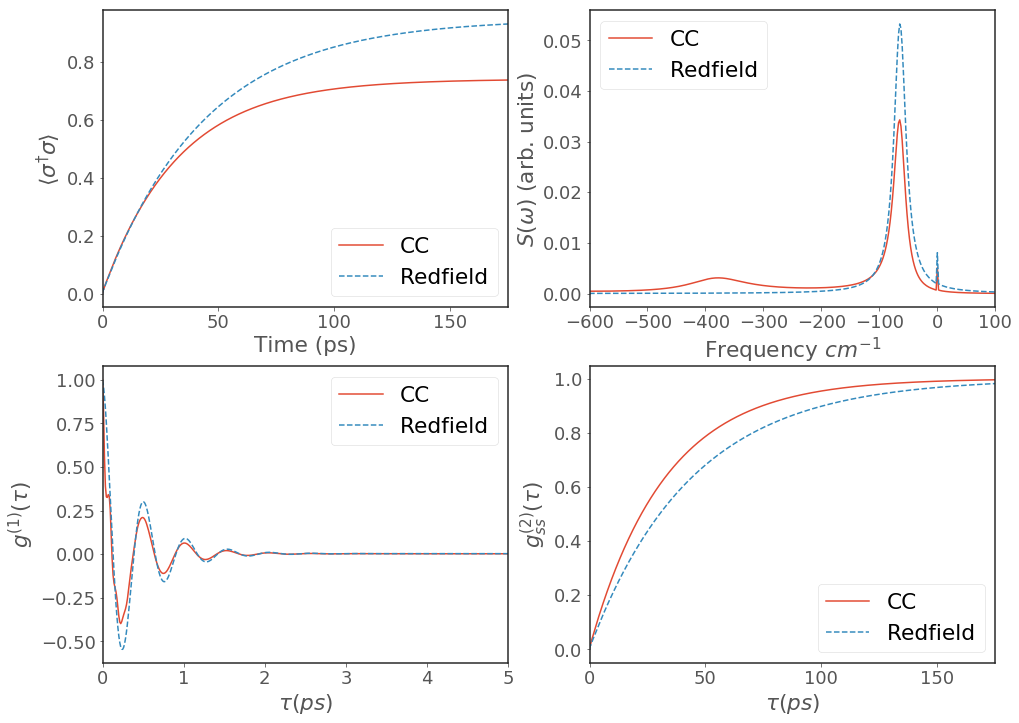

In [126]:
plot_spectra(data_dict_1, freq_window=[-600, 100], 
             tau_window=5, dyn_window_div=1.)

In [169]:
PARAMS = params_ev(detuning=0.1e-3, alpha=6e-3, Rabi=1e-3, w0=20e-3, 
              Gamma=5e-3, T_ph=77., epsilon=1.4, Gamma_EM=7e-07,
              overdamped=False, N=11)

data_dict_2 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

Alpha: 0.006meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 11
Driven Hamiltonian: 
 [[ 0.     +0.j  4.03275+0.j]
 [ 4.03275+0.j -0.80655+0.j]]
Steadystate: 
 [[ 0.33683775+0.j         -0.02833621+0.00046912j]
 [-0.02833621-0.00046912j  0.66316225+0.j        ]]
Completed initial dynamics calculations for Full in 23.900563955307007  seconds.
Completed correlation function calculations for Full in 9.559950113296509 seconds.
G2 took 29.270 seconds
Completed initial dynamics calculations for Redfield in 3.7699520587921143  seconds.
Completed correlation function calculations for Redfield in 5.116074800491333 seconds.
G2 took 0.835 seconds
All spectra calculated.


[-400, 100]
Plot saved at figures/Spectra_WC_comparison.pdf


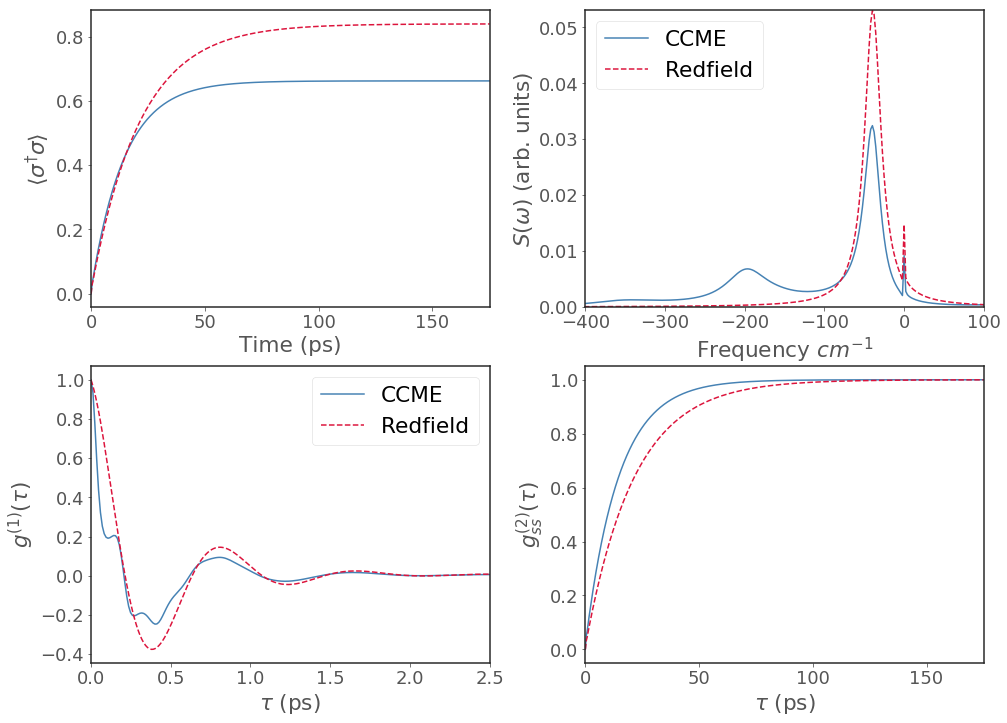

In [206]:
plot_spectra(data_dict_2, freq_window=[-400, 100], 
             tau_window=2.5, dyn_window_div=1., plot_name="Spectra_WC_comparison")

In [171]:
PARAMS = params_ev(detuning=0.1e-3, alpha=10e-3, Rabi=1e-3, w0=20e-3, 
                  Gamma=6e-3, T_ph=77., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_3 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

Alpha: 0.01meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.006meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 12
Driven Hamiltonian: 
 [[ 0.     +0.j  4.03275+0.j]
 [ 4.03275+0.j -0.80655+0.j]]
Steadystate: 
 [[ 0.24832321+0.j         -0.02363613+0.00053527j]
 [-0.02363613-0.00053527j  0.75167679+0.j        ]]
Completed initial dynamics calculations for Full in 38.39308214187622  seconds.
Completed correlation function calculations for Full in 11.373656272888184 seconds.
G2 took 41.495 seconds
Completed initial dynamics calculations for Redfield in 3.7612898349761963  seconds.
Completed correlation function calculations for Redfield in 4.913494825363159 seconds.
G2 took 0.897 seconds
All spectra calculated.


[-500, 100]


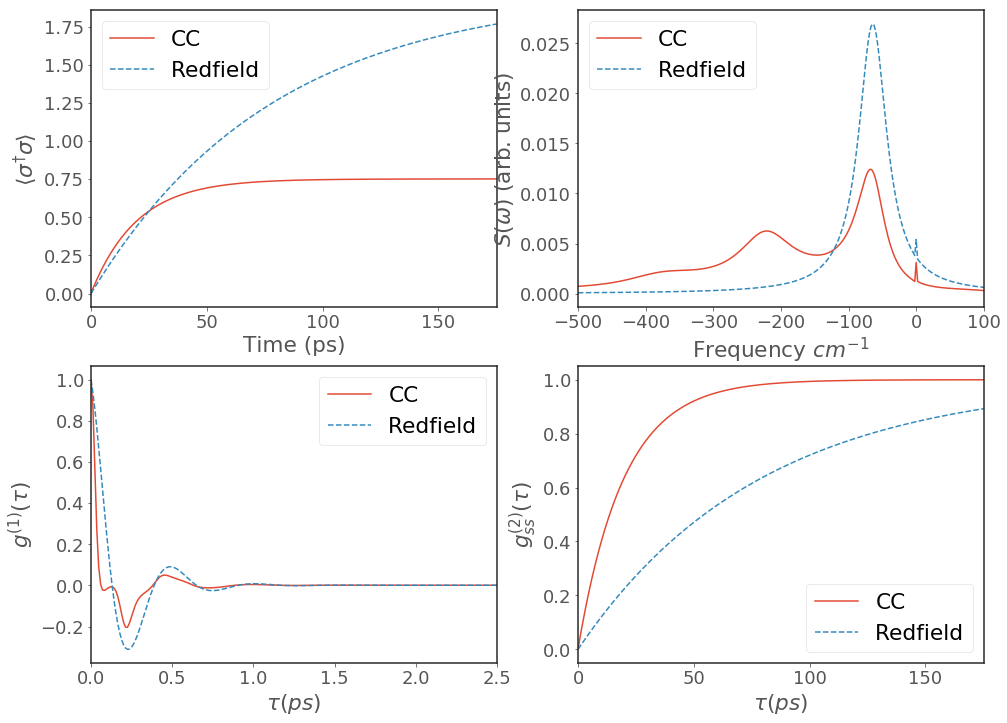

In [172]:
plot_spectra(data_dict_3, freq_window=[-500, 100], 
             tau_window=2.5, dyn_window_div=1.)

In [222]:
PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=77., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

Alpha: 0.014meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 12


In [224]:
J_underdamped, PARAMS['Gamma']

(<function utils.J_underdamped(omega, Gamma, omega_0, alpha=0.0)>, 40.3275)

In [243]:
w = np.linspace(0,100e-3, 3000)
Jw = [J_underdamped(w_, 6e-3, 20e-3, alpha=10e-3) for w_ in w]


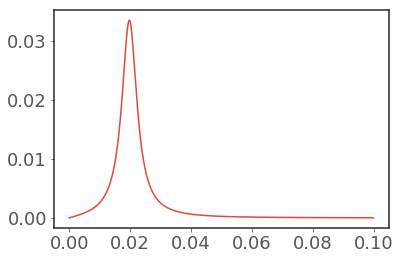

In [244]:
plt.plot(w, Jw)

In [173]:
PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=77., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_4 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

Alpha: 0.014meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 12
Driven Hamiltonian: 
 [[ 0.     +0.j  4.03275+0.j]
 [ 4.03275+0.j -0.80655+0.j]]
Steadystate: 
 [[ 0.18192569+0.j         -0.01944583+0.00058637j]
 [-0.01944583-0.00058637j  0.81807431+0.j        ]]
Completed initial dynamics calculations for Full in 36.68412518501282  seconds.
Completed correlation function calculations for Full in 10.573251008987427 seconds.
G2 took 44.352 seconds
Completed initial dynamics calculations for Redfield in 3.834045886993408  seconds.
Completed correlation function calculations for Redfield in 5.249017953872681 seconds.
G2 took 0.976 seconds
All spectra calculated.


[-500, 100]


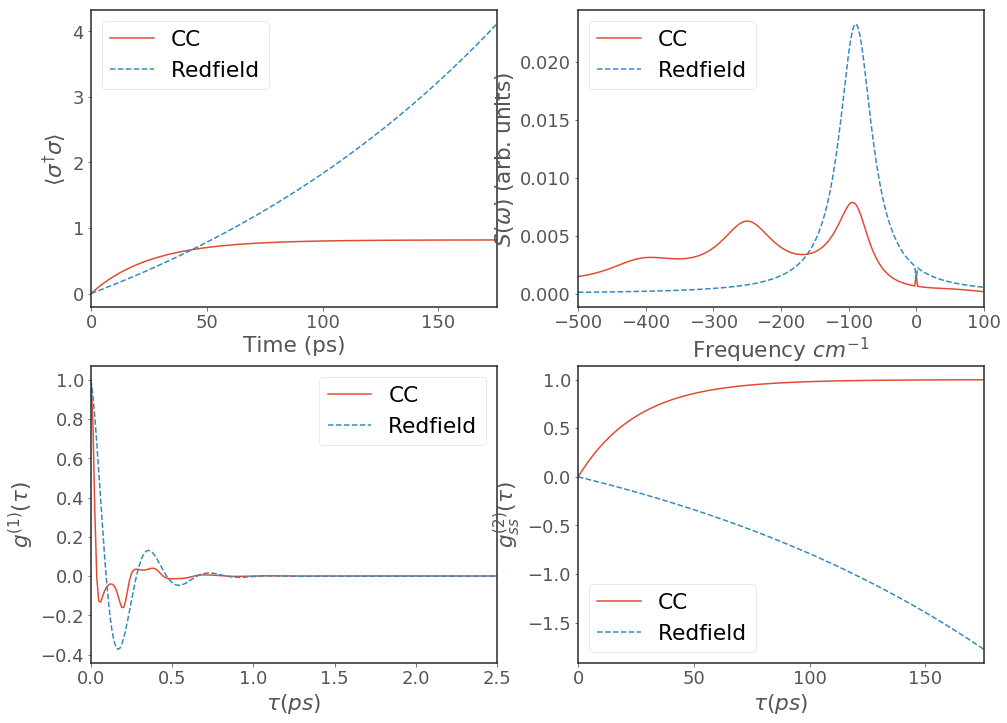

In [174]:
plot_spectra(data_dict_4, freq_window=[-500, 100], 
             tau_window=2.5, dyn_window_div=1.)

Alpha: 0.014meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 10
('Driven Hamiltonian: \n', array([[ 0.     +0.j,  4.03275+0.j],
       [ 4.03275+0.j, -0.80655+0.j]]))
('Steadystate: \n', array([[ 0.05403491+0.j        , -0.02265115+0.00067787j],
       [-0.02265115-0.00067787j,  0.94596509+0.j        ]]))
Completed initial dynamics calculations for Full in 30.2099189758  seconds.
Completed correlation function calculations for Full in 14.3035871983 seconds.
G2 took 33.983 seconds
Completed initial dynamics calculations for Redfield in 5.41961407661  seconds.
Completed correlation function calculations for Redfield in 8.94585084915 seconds.
G2 took 1.244 seconds
All spectra calculated.
[-500, 100]


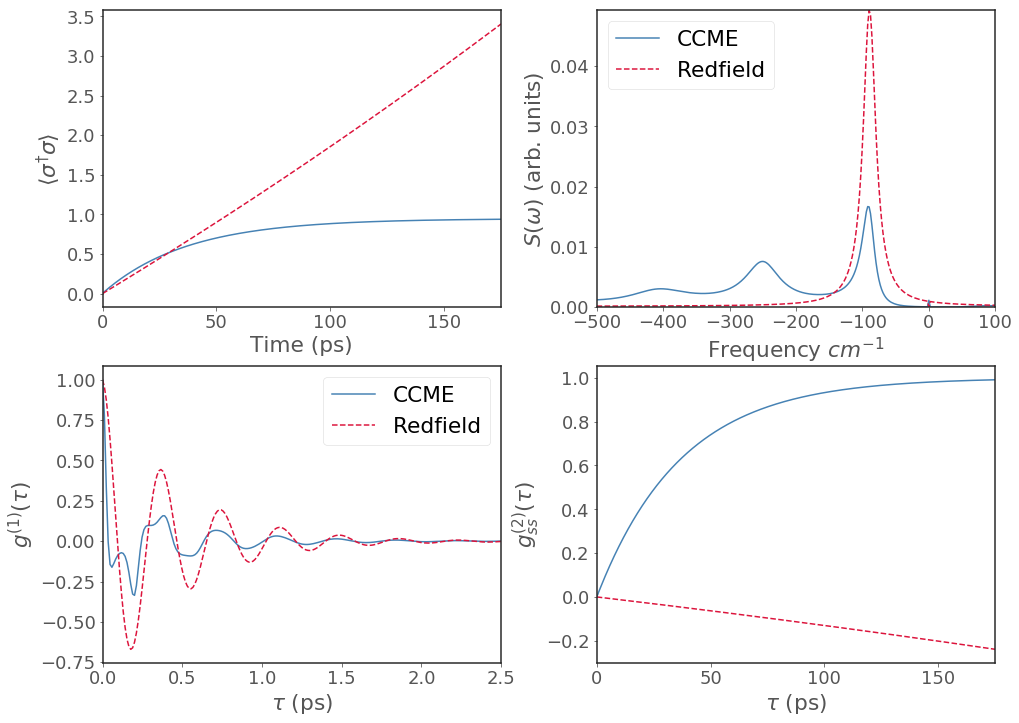

'\nPARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,\n                  Gamma=5e-3, T_ph=40., epsilon=1.4, Gamma_EM=7e-07,\n                  overdamped=False, N=12)\n\ndata_dict_6 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)\n\nPARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,\n                  Gamma=5e-3, T_ph=50., epsilon=1.4, Gamma_EM=7e-07,\n                  overdamped=False, N=12)\n\ndata_dict_7 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)\n\n'

In [28]:
PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=30., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=10)

data_dict_5 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

plot_spectra(data_dict_5, freq_window=[-500, 100], 
             tau_window=2.5, dyn_window_div=1.)
"""
PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=40., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_6 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=50., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_7 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

"""

In [20]:
PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=40., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_6 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

PARAMS = params_ev(detuning=0.1e-3, alpha=14e-3, Rabi=1e-3, w0=20e-3,
                  Gamma=5e-3, T_ph=50., epsilon=1.4, Gamma_EM=7e-07,
                  overdamped=False, N=12)

data_dict_7 = RF_data(PARAMS, t_f=33, steps_per_tau=450, tau_f=3.)

Alpha: 0.014meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 12
('Driven Hamiltonian: \n', array([[ 0.     +0.j,  4.03275+0.j],
       [ 4.03275+0.j, -0.80655+0.j]]))
('Steadystate: \n', array([[ 0.07533325+0.j        , -0.02227717+0.00066262j],
       [-0.02227717-0.00066262j,  0.92466675+0.j        ]]))
Completed initial dynamics calculations for Full in 47.1387090683  seconds.
Completed correlation function calculations for Full in 16.0686998367 seconds.
G2 took 58.533 seconds
Completed initial dynamics calculations for Redfield in 6.19896912575  seconds.
Completed correlation function calculations for Redfield in 9.58497905731 seconds.
G2 took 1.407 seconds
All spectra calculated.
Alpha: 0.014meV, Rabi: 0.001meV, w_laser: 1.4001meV, detuning: 0.0001meV, Gamma: 0.005meV, w0: 0.02meV, Gamma_EM: 7e-07meV, N: 12
('Driven Hamiltonian: \n', array([[ 0.     +0.j,  4.03275+0.j],
       [ 4.03275+0.j, -0.80655+0.j]]))
('Stead

In [29]:
def plot_many_spectra(data_dicts, freq_window=1000., tau_window=False, dyn_window_div = 7., 
                      labels=None, plot_name=None):
    pallete = ['#DC143C', '#FFA500', '#4682B4'][::-1]
    #pallete = ['#DC143C', '#4682B4'][::-1]
    #pallete = ['#DC143C', '#FFA500', '#4682B4'][::-1]
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
    
    #f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    #f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    ls = ['solid', 'solid', 'dotted']
    alphas = [1, 1, 1]
    # 'timelist', 'pop_list', 'taulist', 'g1_data', 'spectrum_data', 'freq_data', 'g2_data'
    for i, data_dict in enumerate(data_dicts):
        freq = data_dict['freq_data']
        timelist = data_dict['timelist']
        taulist = data_dict['taulist']
        spec = data_dict['spectrum_data'][0]
        g_1  = data_dict['g1_data'][0]
        g_2  = data_dict['g2_data'][0]
        freq = data_dict['freq_data'][0]
        ax1.plot(timelist, data_dict['pop_list'][0], linestyle=ls[0], alpha=alphas[i], c=pallete[i])
        ax3.plot(taulist, g_1.real, label=labels[i], linestyle=ls[0], alpha=alphas[i], c=pallete[i])
        ax4.plot(timelist, g_2, linestyle=ls[0], alpha=alphas[i], c=pallete[i])
        ax2.plot(freq, spec, label=labels[i], linestyle=ls[0], alpha=alphas[i], c=pallete[i])
    # plot WC for 6meV
    """
    data_dict = data_dicts[0]
    spec = data_dict['spectrum_data'][1]
    g_1  = data_dict['g1_data'][1]
    g_2  = data_dict['g2_data'][1]
    freq = data_dict['freq_data'][1]
    ax1.plot(timelist, data_dict['pop_list'][1], linestyle=ls[1], alpha=alphas[0], c=pallete[0])
    ax3.plot(taulist, g_1.real, linestyle=ls[1], alpha=alphas[0], c=pallete[0])
    ax4.plot(timelist, g_2, linestyle=ls[1], alpha=alphas[0], c=pallete[0])
    ax2.plot(freq, spec, linestyle=ls[1], alpha=alphas[0], c=pallete[0])
    """
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    if tau_window:
        ax3.set_xlim(0,tau_window)
    else:
        ax3.set_xlim(0,taulist[-1])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    ax4.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax1.set_xlabel(r"Time (ps)")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    ax2.set_ylim(0,max(data_dicts[0]['spectrum_data'][0])+4e-3)
    if freq_window is not None:
        if type(freq_window) in [float, int]:
            ax2.set_xlim(-freq_window,freq_window)
        else:
            print (freq_window)
            ax2.set_xlim(freq_window[0],freq_window[1])
    ax1.set_ylabel(r"$\langle\sigma^{\dagger}\sigma \rangle $")
    ax2.set_ylabel(r"$S(\omega)$ (arb. units)")
    ax3.set_ylabel(r"$g^{(1)}(\tau)$") # coherence
    #ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$g^{(2)}_{ss}(\tau)$") # coherence
    ax3.set_xlabel(r"$\tau (ps)$")
    #ax4.set_xlabel(r"$\tau$") # if lower right is imag part of g1
    ax4.set_xlabel(r"$\tau (ps)$")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=None)
    #ax1.legend()
    ax2.legend()
    ax3.legend()
    #ax4.legend()
    if plot_name is not None:
        name = "figures/"+plot_name+'.pdf'
        plt.savefig(name)
        print("Plot saved at "+ name)
    plt.show()
"""
plot_many_spectra([data_dict_2, data_dict_3, data_dict_4], freq_window=[-400, 50], 
             tau_window=2.5, dyn_window_div=1., labels=[r'$\alpha=6meV$', r'$\alpha=10meV$', r'$\alpha=14meV$'])

plot_many_spectra([data_dict_2,  data_dict_4], freq_window=[-400, 50], 
             tau_window=2.5, dyn_window_div=1., labels=[r'$\alpha=6meV$', r'$\alpha=14meV$'], 
                  plot_name='spectra_sheffield')
"""

"\nplot_many_spectra([data_dict_2, data_dict_3, data_dict_4], freq_window=[-400, 50], \n             tau_window=2.5, dyn_window_div=1., labels=[r'$\x07lpha=6meV$', r'$\x07lpha=10meV$', r'$\x07lpha=14meV$'])\n\nplot_many_spectra([data_dict_2,  data_dict_4], freq_window=[-400, 50], \n             tau_window=2.5, dyn_window_div=1., labels=[r'$\x07lpha=6meV$', r'$\x07lpha=14meV$'], \n                  plot_name='spectra_sheffield')\n"

[-600, 50]
Plot saved at figures/spectra_sheffield_TD.pdf


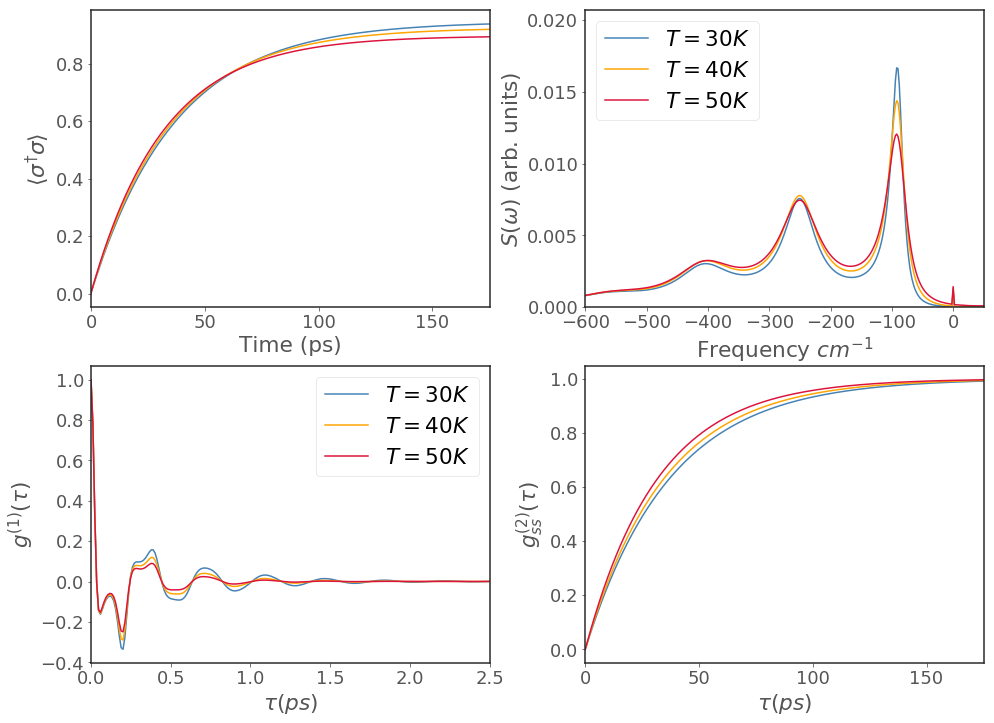

In [34]:
plot_many_spectra([data_dict_5,  data_dict_6,  data_dict_7], freq_window=[-600, 50], 
             tau_window=2.5, dyn_window_div=1., labels=[r'$T=30K$',r'$T=40K$', r'$T=50K$'], 
                  plot_name='spectra_sheffield_TD')

In [221]:
inv_ps_to_inv_cm

530.9

# No phonons

Alpha: 0, Rabi: 1.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
 [[0. +0.j 0.5+0.j]
 [0.5+0.j 0. +0.j]]
Steadystate: 
 [[0.66672221+0.j         0.        +0.33344443j]
 [0.        -0.33344443j 0.33327779+0.j        ]]
Completed initial dynamics calculations for Full in 1.770665168762207  seconds.
Completed correlation function calculations for Full in 3.971349000930786 seconds.
G2 took 0.421 seconds
Steadystate: 
 [[0.66672221+0.j         0.        +0.33344443j]
 [0.        -0.33344443j 0.33327779+0.j        ]]
Completed initial dynamics calculations for Naive in 1.6953389644622803  seconds.
Completed correlation function calculations for Naive in 4.076038837432861 seconds.
G2 took 0.387 seconds
All spectra calculated.


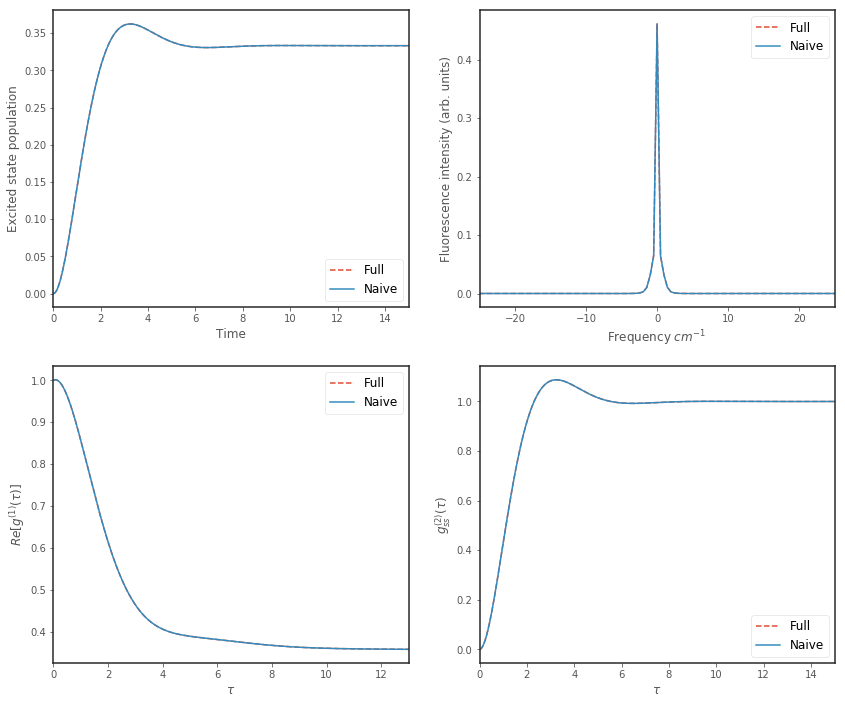

Alpha: 0, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
 [[0.+0.j 5.+0.j]
 [5.+0.j 0.+0.j]]
Steadystate: 
 [[0.50249994+0.j         0.        +0.04999876j]
 [0.        -0.04999876j 0.49750006+0.j        ]]
Completed initial dynamics calculations for Full in 1.8026299476623535  seconds.
Completed correlation function calculations for Full in 3.5991039276123047 seconds.
G2 took 0.360 seconds
Steadystate: 
 [[0.50249994+0.j         0.        +0.04999876j]
 [0.        -0.04999876j 0.49750006+0.j        ]]
Completed initial dynamics calculations for Naive in 1.885448932647705  seconds.
Completed correlation function calculations for Naive in 3.5515360832214355 seconds.
G2 took 0.371 seconds
All spectra calculated.


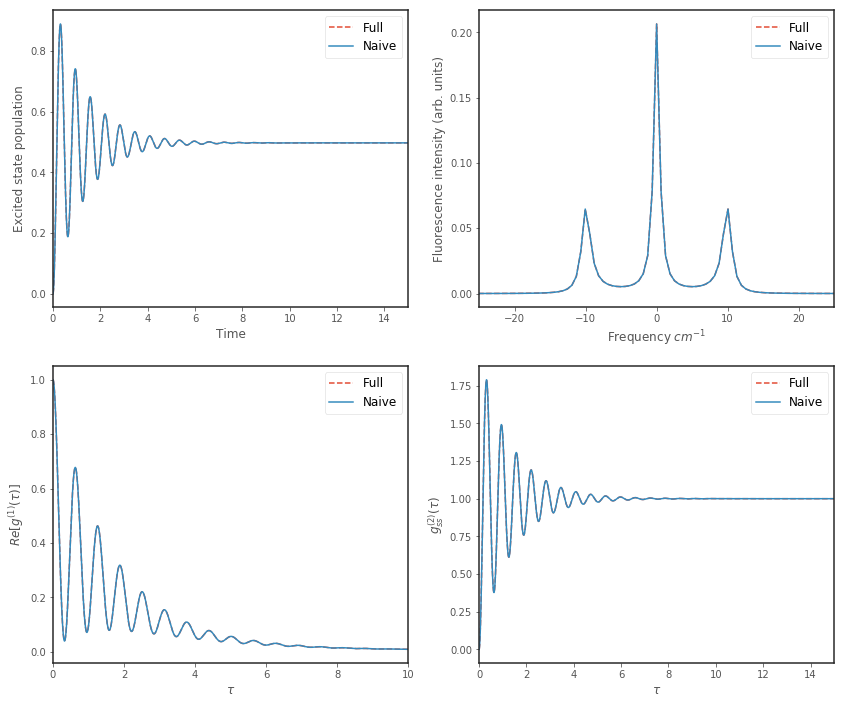

Alpha: 0, Rabi: 1.0, w_laser: 1010.0, detuning: 10.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
 [[  0. +0.j   0.5+0.j]
 [  0.5+0.j -10. +0.j]]
Steadystate: 
 [[0.99751886+0.j         0.04962408+0.00250608j]
 [0.04962408-0.00250608j 0.00248114+0.j        ]]
Completed initial dynamics calculations for Full in 1.8187971115112305  seconds.
Completed correlation function calculations for Full in 3.739748239517212 seconds.
G2 took 0.359 seconds
Steadystate: 
 [[0.99751886+0.j         0.04962408+0.00250608j]
 [0.04962408-0.00250608j 0.00248114+0.j        ]]
Completed initial dynamics calculations for Naive in 1.7907562255859375  seconds.
Completed correlation function calculations for Naive in 3.4933230876922607 seconds.
G2 took 0.365 seconds
All spectra calculated.


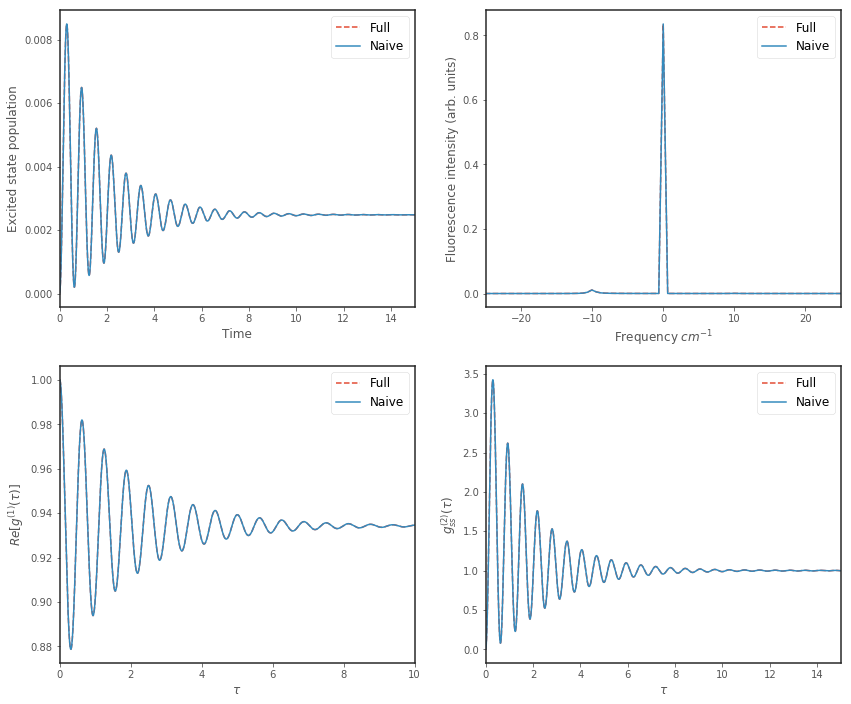

Alpha: 0, Rabi: 10.0, w_laser: 1010.0, detuning: 10.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
 [[  0.+0.j   5.+0.j]
 [  5.+0.j -10.+0.j]]
Steadystate: 
 [[0.83362116+0.j         0.33276361+0.01686308j]
 [0.33276361-0.01686308j 0.16637884+0.j        ]]
Completed initial dynamics calculations for Full in 1.7876808643341064  seconds.
Completed correlation function calculations for Full in 3.6379592418670654 seconds.
G2 took 0.382 seconds
Steadystate: 
 [[0.83362116+0.j         0.33276361+0.01686308j]
 [0.33276361-0.01686308j 0.16637884+0.j        ]]
Completed initial dynamics calculations for Naive in 1.7693660259246826  seconds.
Completed correlation function calculations for Naive in 3.5745818614959717 seconds.
G2 took 0.404 seconds
All spectra calculated.


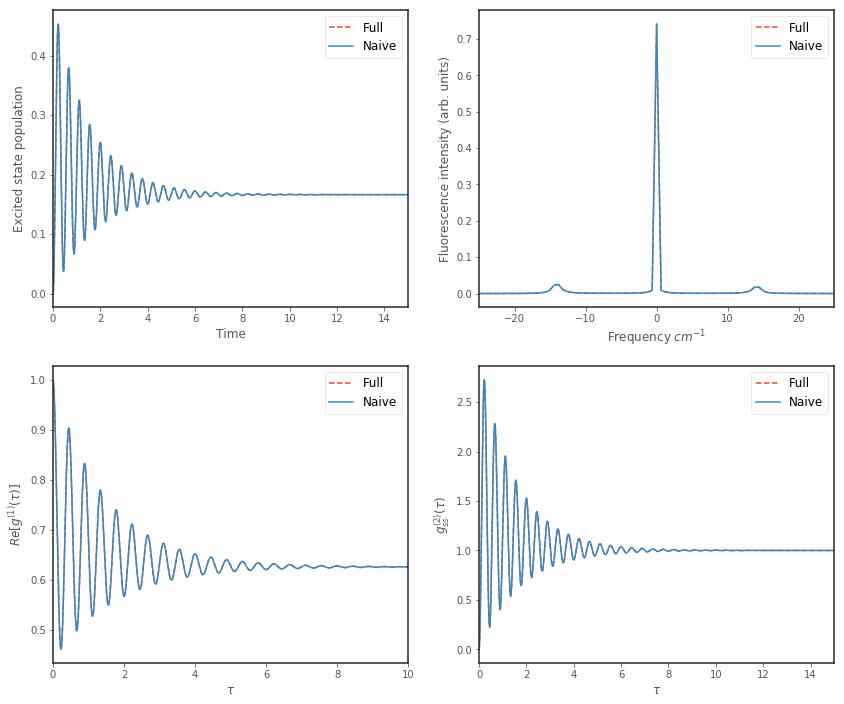

In [23]:

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=13.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=10., 
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=10.,
                                                                             t_f=15, steps_per_tau=500,
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

Alpha: 5.0, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 15, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.60513629+0.j         -0.04306876+0.04178621j]
 [-0.04306876-0.04178621j  0.39486371+0.j        ]]
Completed initial dynamics calculations for Full in 4.21217894554  seconds.
Completed correlation function calculations for Full in 2.72055006027 seconds.
G2 took 1.516 seconds
Steadystate: 
[[ 0.60146925+0.j         -0.04316373+0.04045687j]
 [-0.04316373-0.04045687j  0.39853075+0.j        ]]
Completed initial dynamics calculations for Naive in 4.36045217514  seconds.
Completed correlation function calculations for Naive in 2.59586215019 seconds.
G2 took 1.271 seconds
All spectra calculated.


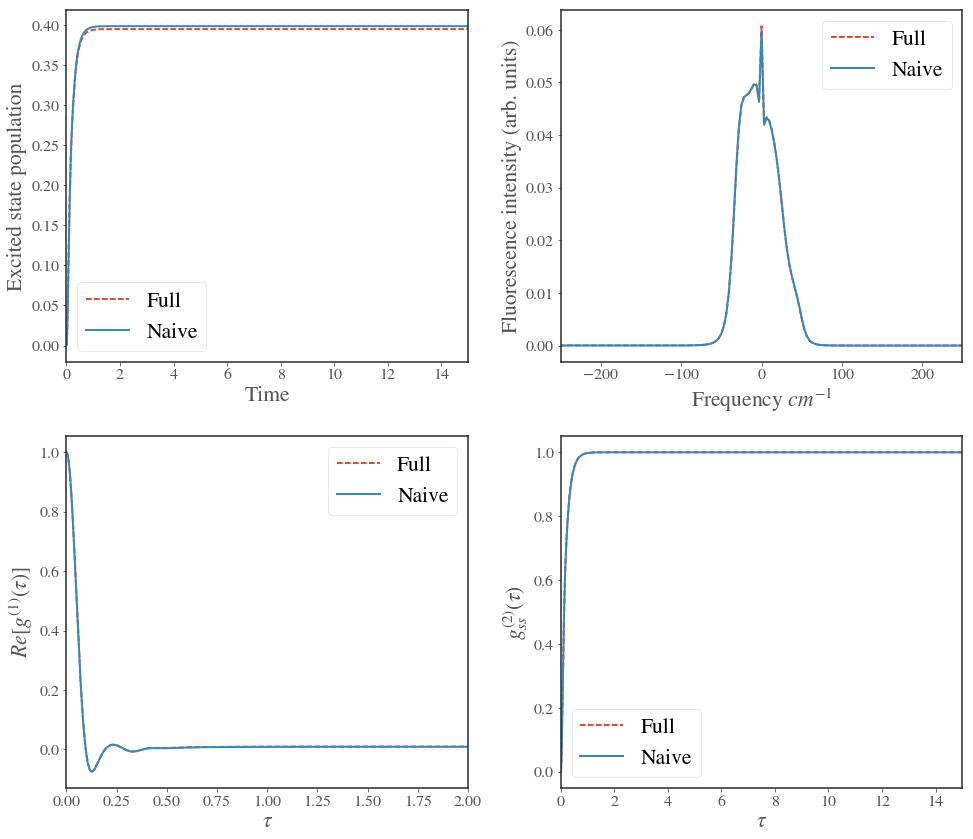

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 20, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.60187157+0.j         -0.04478994+0.04232969j]
 [-0.04478994-0.04232969j  0.39812843+0.j        ]]
Completed initial dynamics calculations for Full in 4.64680099487  seconds.
Completed correlation function calculations for Full in 2.72209310532 seconds.
G2 took 1.031 seconds
Steadystate: 
[[ 0.59805303+0.j         -0.04484988+0.04080367j]
 [-0.04484988-0.04080367j  0.40194697+0.j        ]]
Completed initial dynamics calculations for Naive in 4.05975079536  seconds.
Completed correlation function calculations for Naive in 2.54902410507 seconds.
G2 took 0.913 seconds
All spectra calculated.


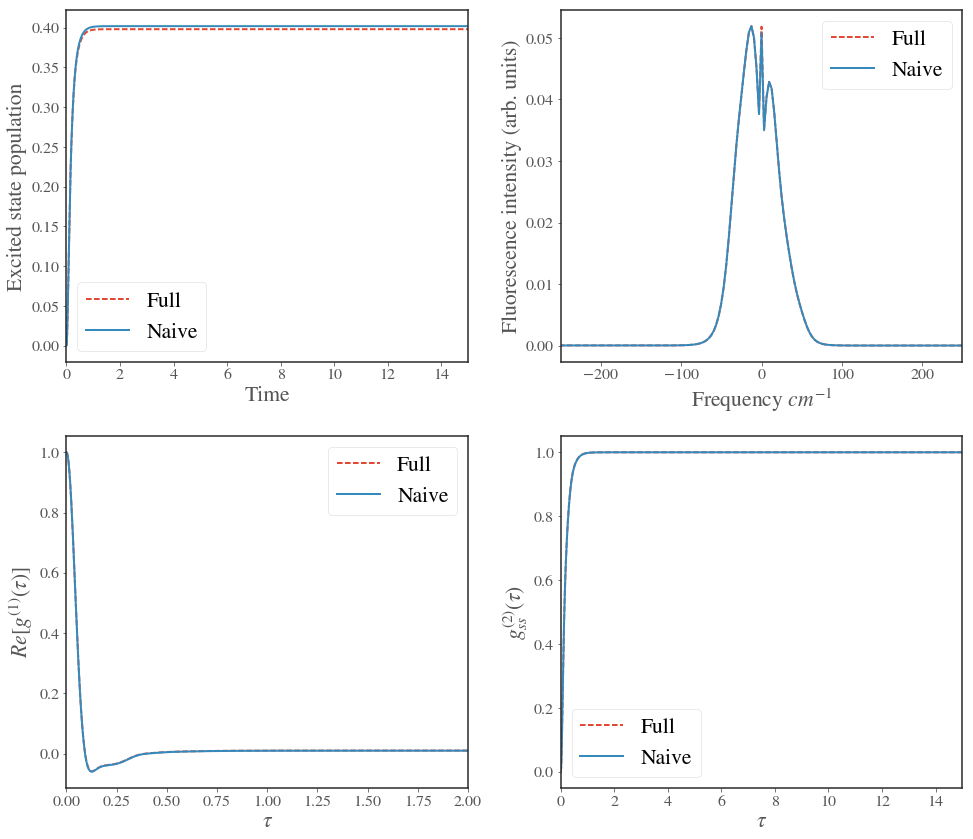

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 25, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.59588741+0.j         -0.04404057+0.04304118j]
 [-0.04404057-0.04304118j  0.40411259+0.j        ]]
Completed initial dynamics calculations for Full in 4.03971886635  seconds.
Completed correlation function calculations for Full in 2.46122503281 seconds.
G2 took 0.928 seconds
Steadystate: 
[[ 0.59207185+0.j         -0.04410148+0.04141085j]
 [-0.04410148-0.04141085j  0.40792815+0.j        ]]
Completed initial dynamics calculations for Naive in 3.21066403389  seconds.
Completed correlation function calculations for Naive in 2.19584298134 seconds.
G2 took 0.804 seconds
All spectra calculated.


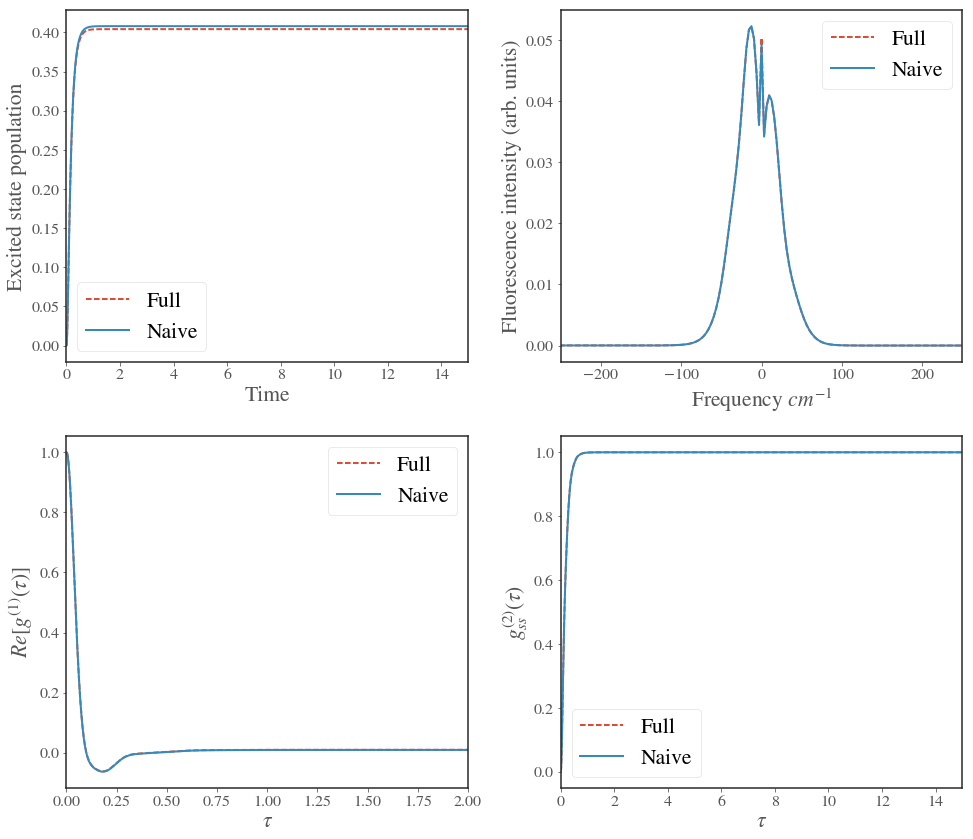

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 30, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.58072435+0.j        -0.04413903+0.0446596j]
 [-0.04413903-0.0446596j  0.41927565+0.j       ]]
Completed initial dynamics calculations for Full in 3.10691094398  seconds.
Completed correlation function calculations for Full in 2.99224901199 seconds.
G2 took 1.217 seconds
Steadystate: 
[[ 0.57726540+0.j         -0.04416321+0.04291392j]
 [-0.04416321-0.04291392j  0.42273460+0.j        ]]
Completed initial dynamics calculations for Naive in 4.09523582458  seconds.
Completed correlation function calculations for Naive in 3.01611709595 seconds.
G2 took 0.739 seconds
All spectra calculated.


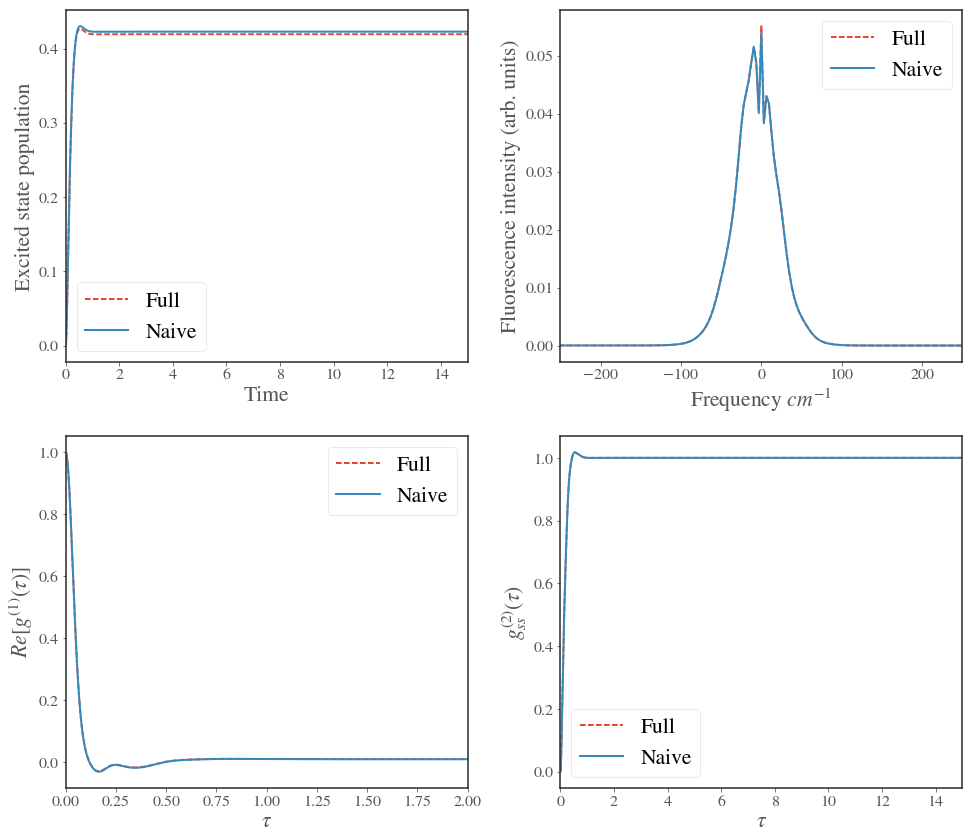

In [272]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5., Rabi=10., w0=15,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
             freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=20,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=25,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=30,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

# Mollow regime

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.297214984894  seconds to build the Non-secular RWA Liouvillian
It took  0.110357999802  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.52933857+0.j         -0.08660900+0.02135692j]
 [-0.08660900-0.02135692j  0.47066143+0.j        ]]
Completed initial dynamics calculations for Full in 1.04757094383  seconds.
Completed correlation function calculations for Full in 1.40378785133 seconds.
G2 took 0.345 seconds
All spectra calculated.


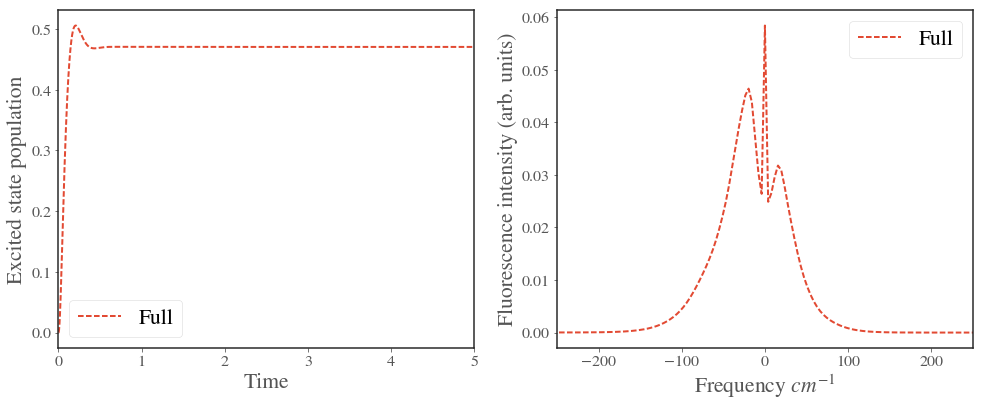

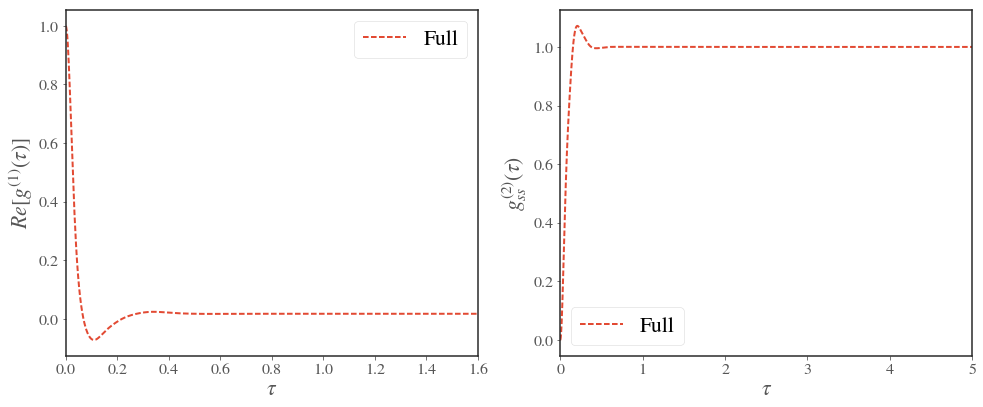

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.275485038757  seconds to build the Non-secular RWA Liouvillian
It took  0.108073949814  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63472803+0.j         -0.07346119+0.01420677j]
 [-0.07346119-0.01420677j  0.36527197+0.j        ]]
Completed initial dynamics calculations for Full in 1.28875184059  seconds.
Completed correlation function calculations for Full in 0.905956983566 seconds.
G2 took 0.184 seconds
All spectra calculated.


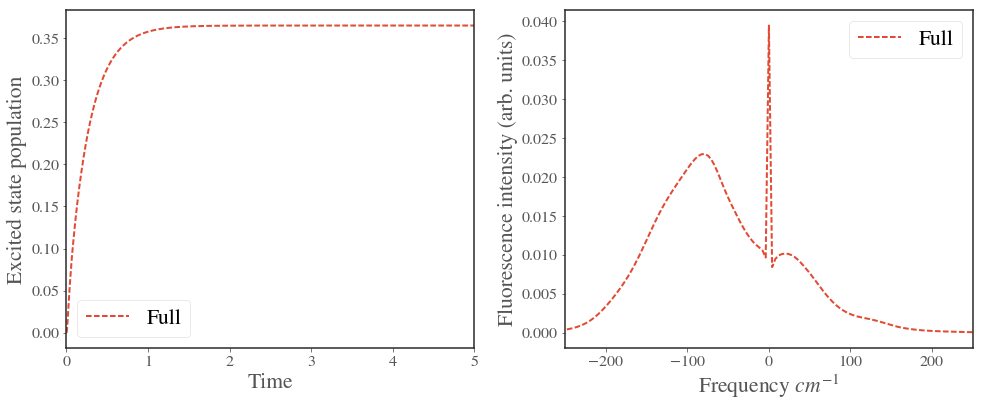

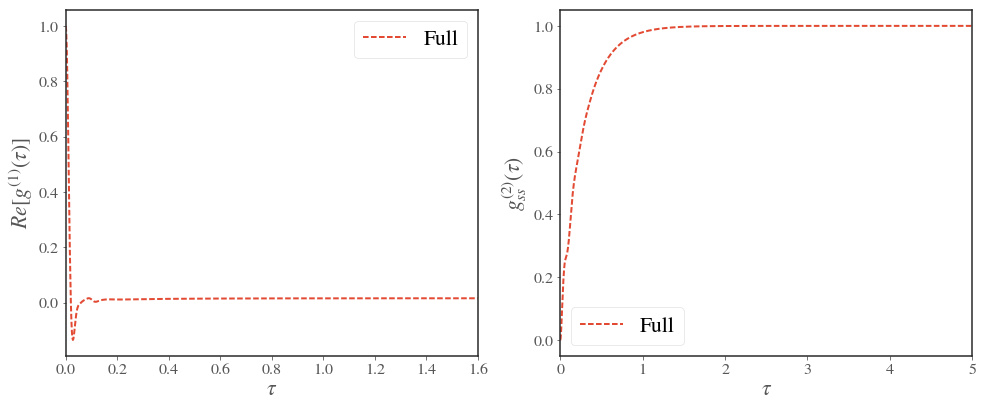

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.243406057358  seconds to build the Non-secular RWA Liouvillian
It took  0.112782001495  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.55218586+0.j         -0.08371705+0.02042897j]
 [-0.08371705-0.02042897j  0.44781414+0.j        ]]
Completed initial dynamics calculations for Full in 1.07741498947  seconds.
Completed correlation function calculations for Full in 0.840218067169 seconds.
G2 took 0.345 seconds
All spectra calculated.


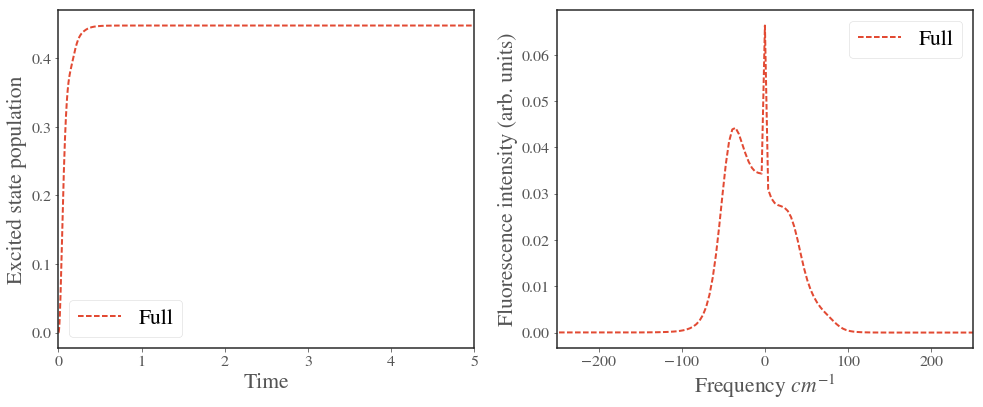

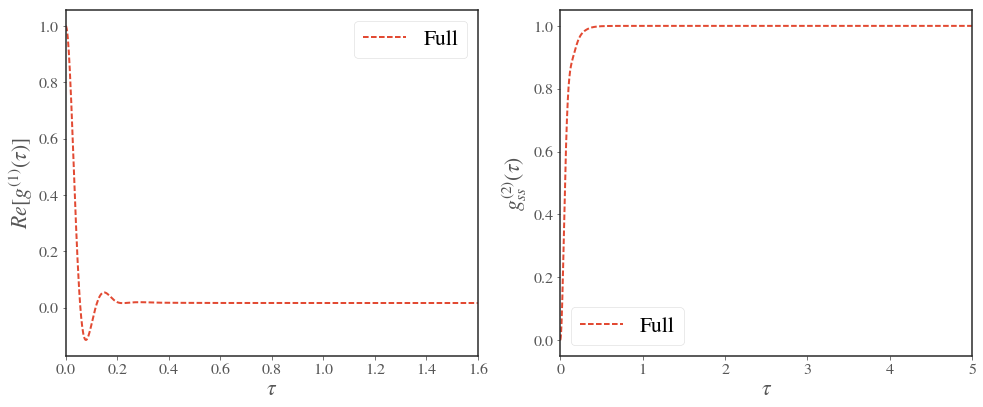

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.394037008286  seconds to build the Non-secular RWA Liouvillian
It took  0.136216878891  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.70664933+0.j         -0.07569085+0.01246527j]
 [-0.07569085-0.01246527j  0.29335067+0.j        ]]
Completed initial dynamics calculations for Full in 1.21641302109  seconds.
Completed correlation function calculations for Full in 0.901777029037 seconds.
G2 took 0.351 seconds
All spectra calculated.


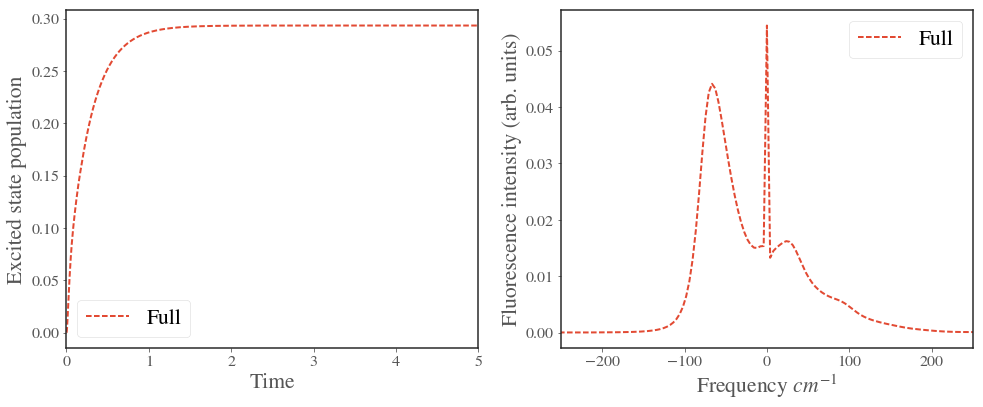

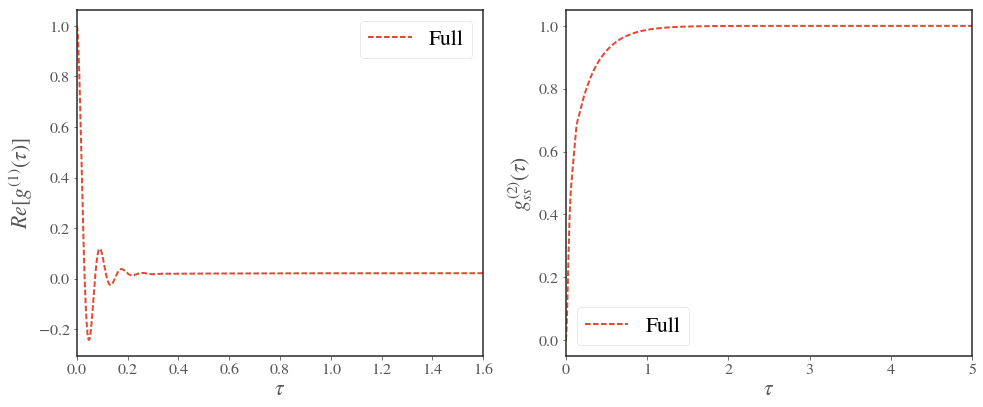

In [86]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)


timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

## Mollow and detuning $\Delta \approx \alpha$

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.256452083588  seconds to build the Non-secular RWA Liouvillian
It took  0.106600046158  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.40143675+0.j         -0.04040244+0.02860469j]
 [-0.04040244-0.02860469j  0.59856325+0.j        ]]
Completed initial dynamics calculations for Full in 0.999963998795  seconds.
Completed correlation function calculations for Full in 0.936197042465 seconds.
G2 took 0.225 seconds
All spectra calculated.


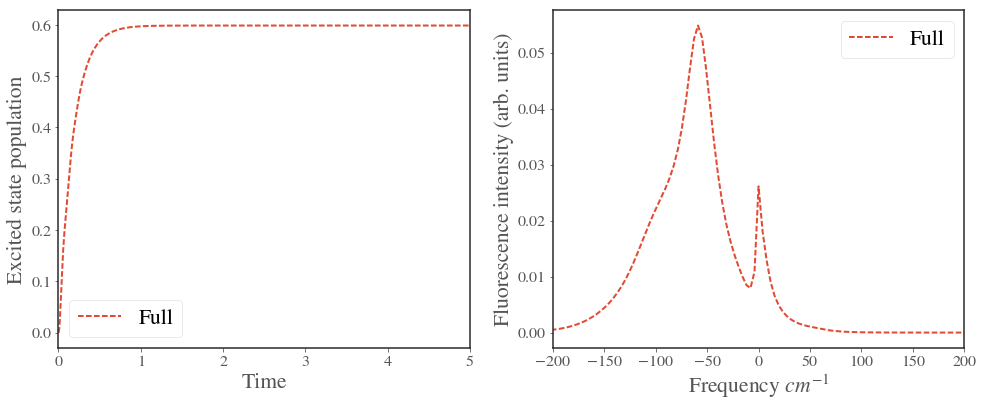

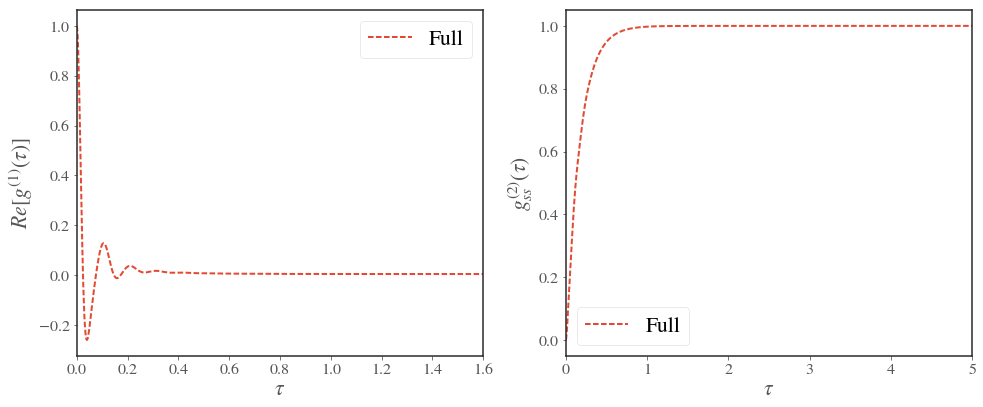

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.430556058884  seconds to build the Non-secular RWA Liouvillian
It took  0.195210933685  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.44763848+0.j        -0.06049992+0.0226746j]
 [-0.06049992-0.0226746j  0.55236152+0.j       ]]
Completed initial dynamics calculations for Full in 1.47141098976  seconds.
Completed correlation function calculations for Full in 0.998790979385 seconds.
G2 took 0.320 seconds
All spectra calculated.


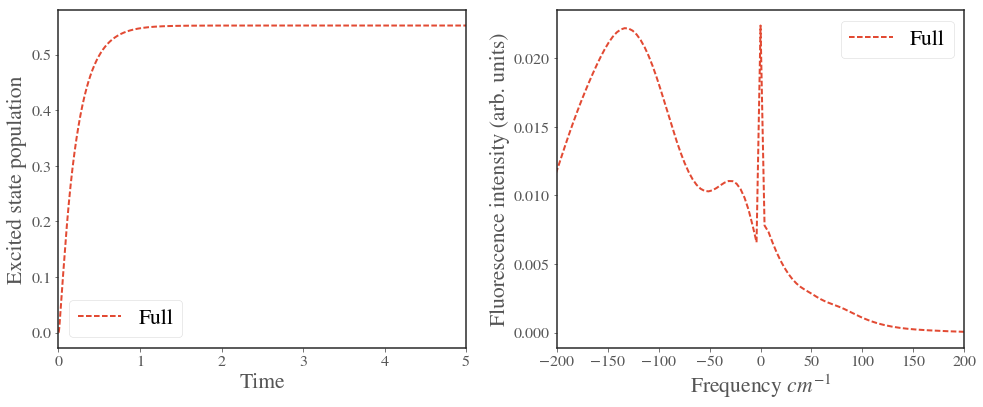

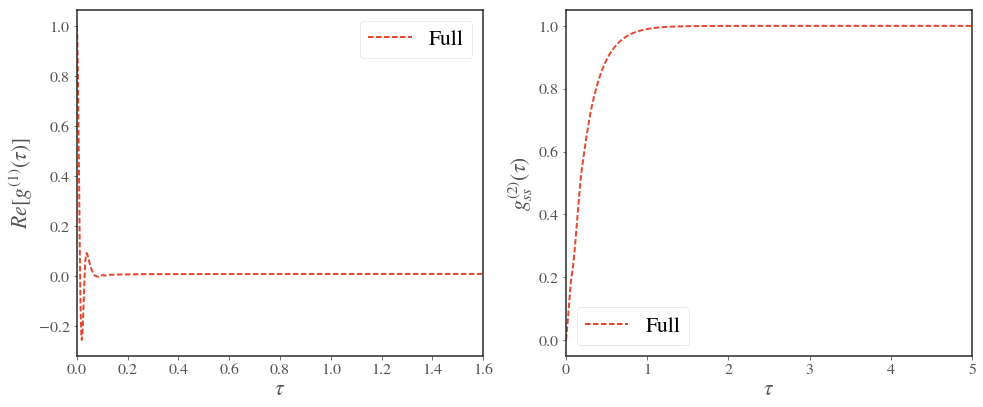

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.235013008118  seconds to build the Non-secular RWA Liouvillian
It took  0.105239152908  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.45408069+0.j         -0.02021569+0.02678793j]
 [-0.02021569-0.02678793j  0.54591931+0.j        ]]
Completed initial dynamics calculations for Full in 1.3853700161  seconds.
Completed correlation function calculations for Full in 0.984528064728 seconds.
G2 took 0.331 seconds
All spectra calculated.


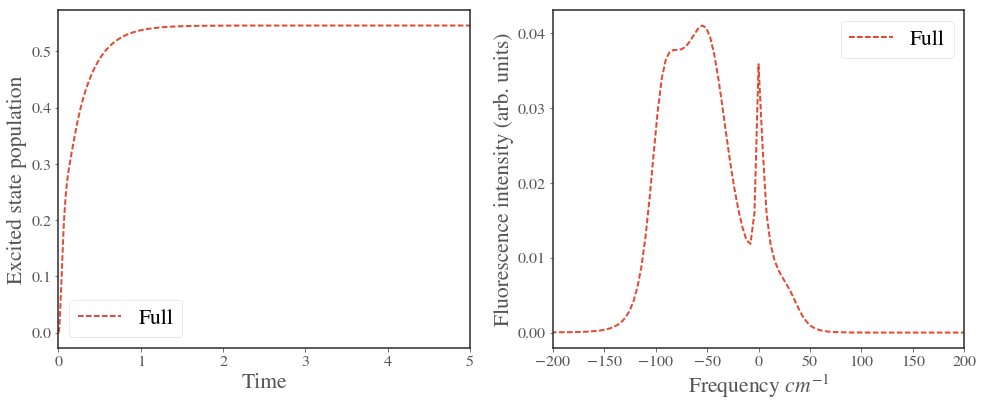

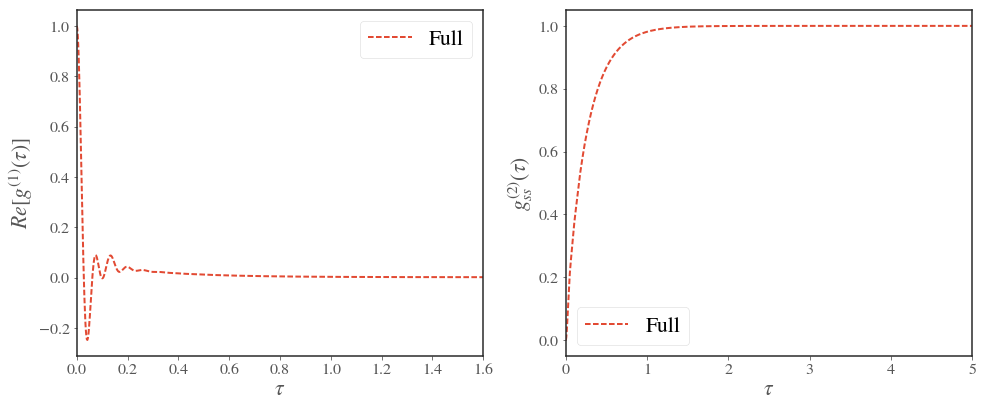

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.251060009003  seconds to build the Non-secular RWA Liouvillian
It took  0.111477136612  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.54646886+0.j         -0.06106285+0.02091363j]
 [-0.06106285-0.02091363j  0.45353114+0.j        ]]
Completed initial dynamics calculations for Full in 1.19408082962  seconds.
Completed correlation function calculations for Full in 0.923207998276 seconds.
G2 took 0.385 seconds
All spectra calculated.


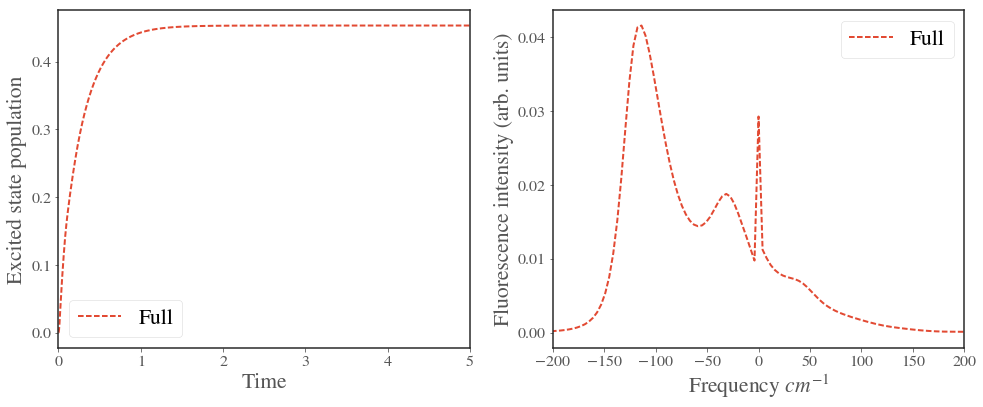

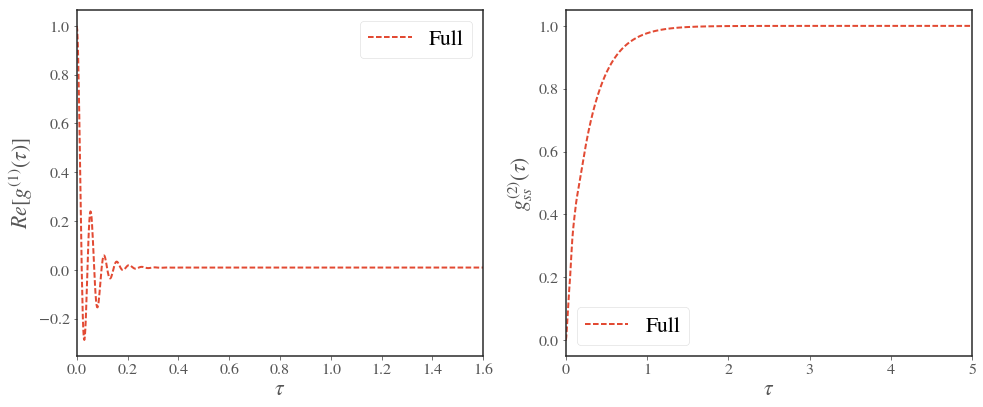

In [87]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.286993026733  seconds to build the Non-secular RWA Liouvillian
It took  0.122004985809  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.82304565+0.j          0.02605197+0.03397906j]
 [ 0.02605197-0.03397906j  0.17695435+0.j        ]]
Completed initial dynamics calculations for Full in 1.04502606392  seconds.
Completed correlation function calculations for Full in 1.02417778969 seconds.
G2 took 0.215 seconds
All spectra calculated.


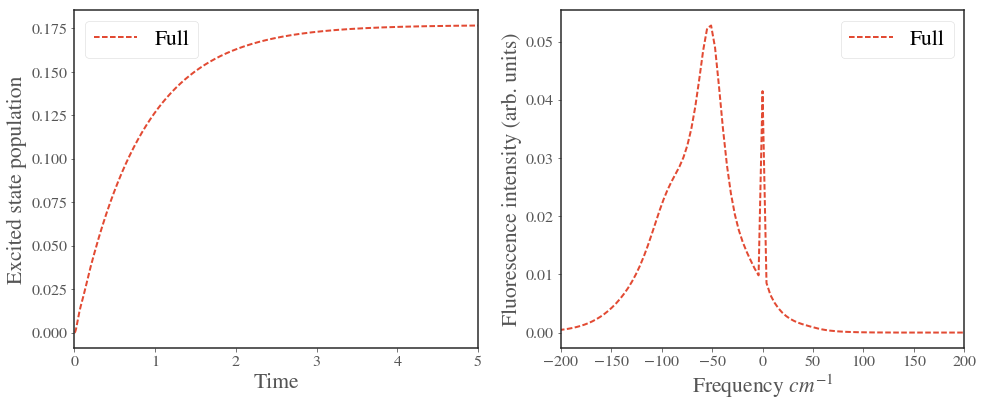

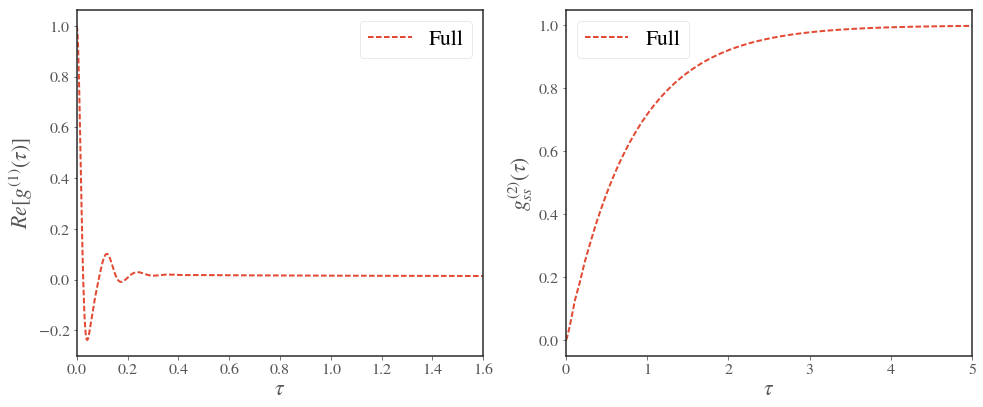

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.434901952744  seconds to build the Non-secular RWA Liouvillian
It took  0.216999053955  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.84270170+0.j         -0.00874687+0.02587545j]
 [-0.00874687-0.02587545j  0.15729830+0.j        ]]
Completed initial dynamics calculations for Full in 1.15030813217  seconds.
Completed correlation function calculations for Full in 1.27779388428 seconds.
G2 took 0.249 seconds
All spectra calculated.


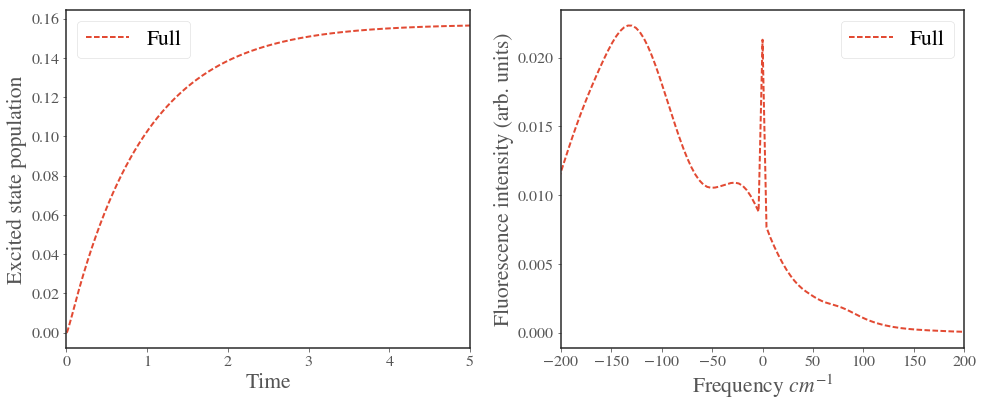

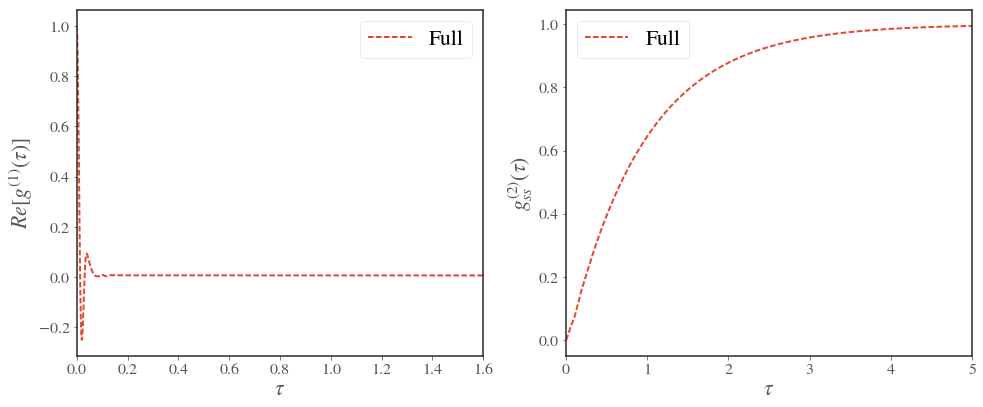

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.248783111572  seconds to build the Non-secular RWA Liouvillian
It took  0.112131118774  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.81409066+0.j          0.02750335+0.03662224j]
 [ 0.02750335-0.03662224j  0.18590934+0.j        ]]
Completed initial dynamics calculations for Full in 1.26788902283  seconds.
Completed correlation function calculations for Full in 1.05401015282 seconds.
G2 took 0.417 seconds
All spectra calculated.


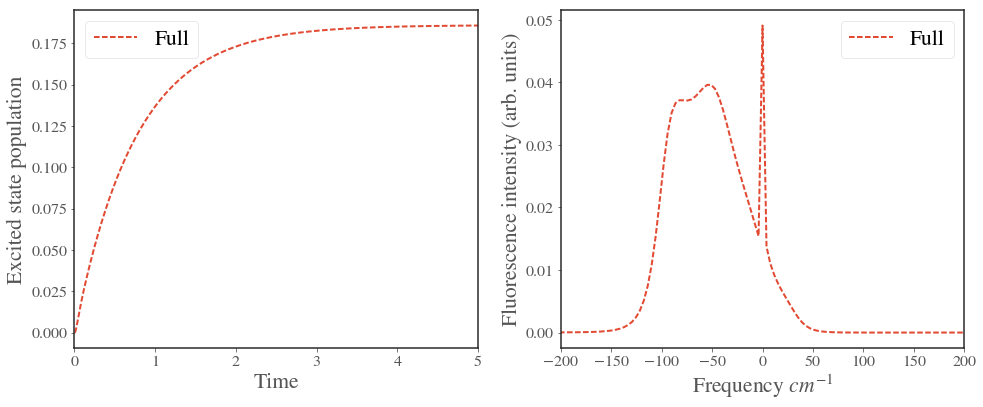

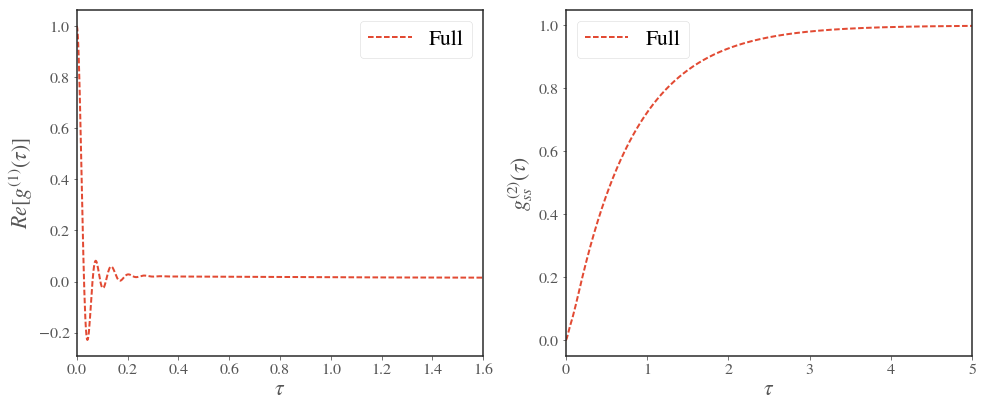

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.268938064575  seconds to build the Non-secular RWA Liouvillian
It took  0.110217809677  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.88266501+0.j         -0.00850074+0.02173076j]
 [-0.00850074-0.02173076j  0.11733499+0.j        ]]
Completed initial dynamics calculations for Full in 1.26002717018  seconds.
Completed correlation function calculations for Full in 1.53465509415 seconds.
G2 took 0.363 seconds
All spectra calculated.


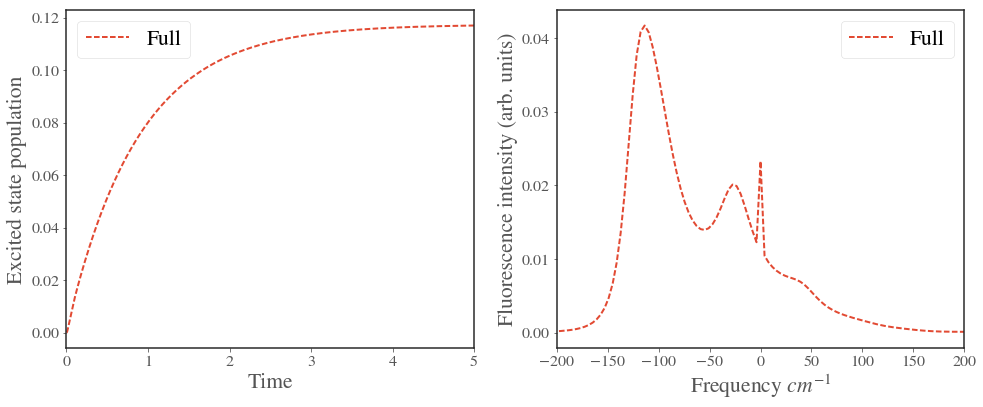

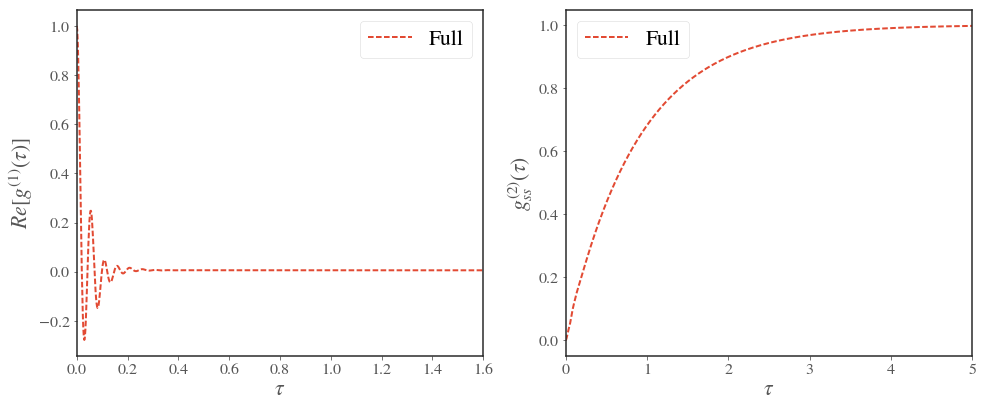

In [11]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.367541790009  seconds to build the Non-secular RWA Liouvillian
It took  0.157804012299  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.57466709+0.j         -0.00737967+0.03893123j]
 [-0.00737967-0.03893123j  0.42533291+0.j        ]]
Completed initial dynamics calculations for Full in 1.07669496536  seconds.
Completed correlation function calculations for Full in 0.993422031403 seconds.
G2 took 0.261 seconds
All spectra calculated.


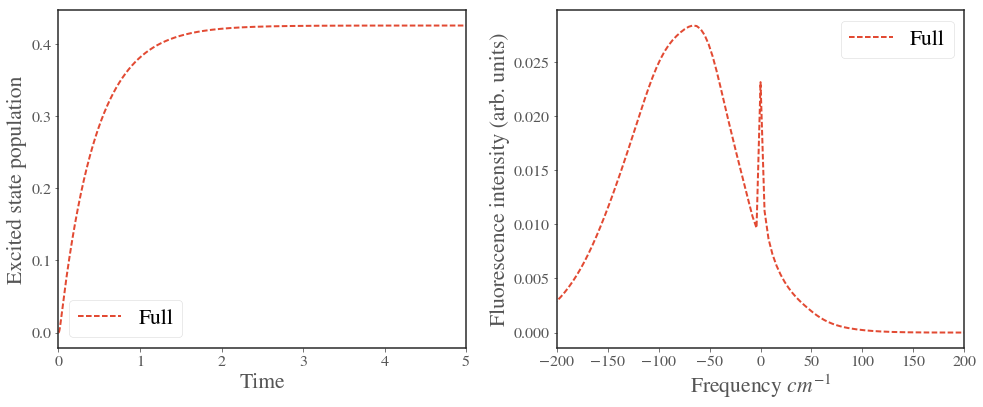

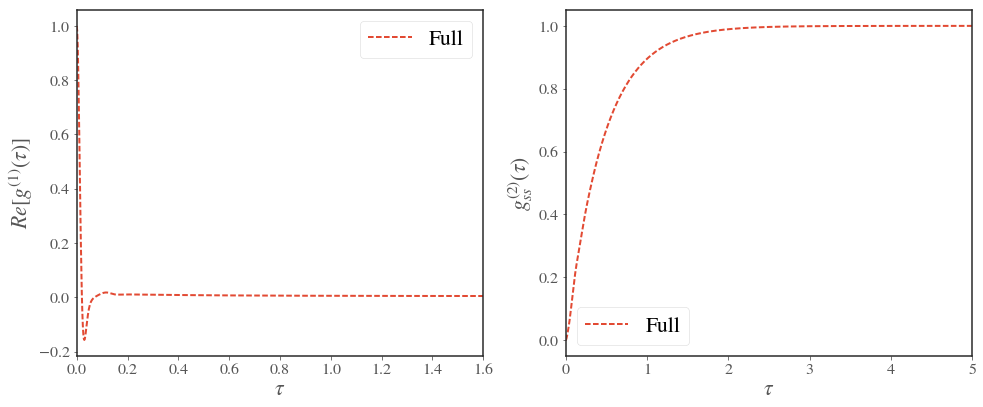

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.760421037674  seconds to build the Non-secular RWA Liouvillian
It took  0.163596868515  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58746992+0.j        -0.02731942+0.0368351j]
 [-0.02731942-0.0368351j  0.41253008+0.j       ]]
Completed initial dynamics calculations for Full in 1.4600110054  seconds.
Completed correlation function calculations for Full in 0.97552895546 seconds.
G2 took 0.306 seconds
All spectra calculated.


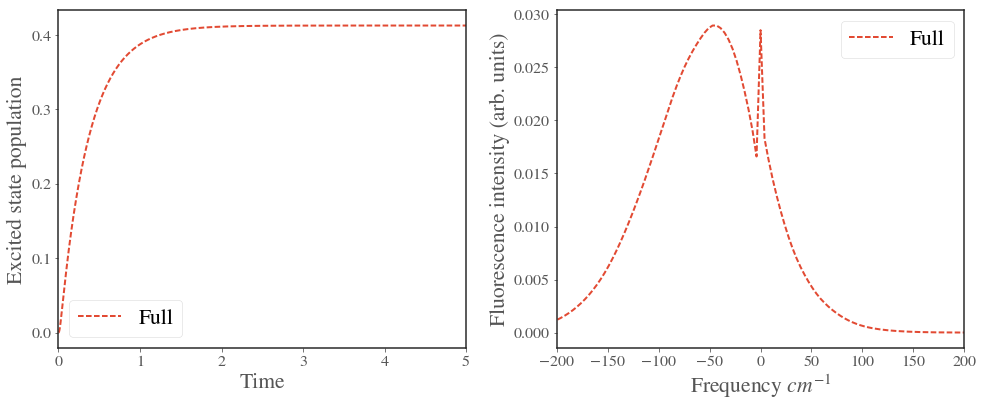

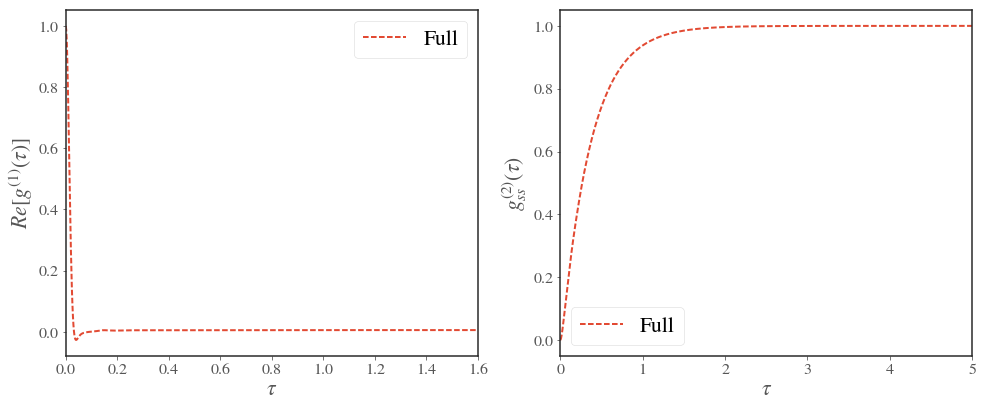

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.316792011261  seconds to build the Non-secular RWA Liouvillian
It took  0.1518471241  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58594808+0.j         -0.01026351+0.03925943j]
 [-0.01026351-0.03925943j  0.41405192+0.j        ]]
Completed initial dynamics calculations for Full in 1.84336709976  seconds.
Completed correlation function calculations for Full in 0.991064071655 seconds.
G2 took 0.585 seconds
All spectra calculated.


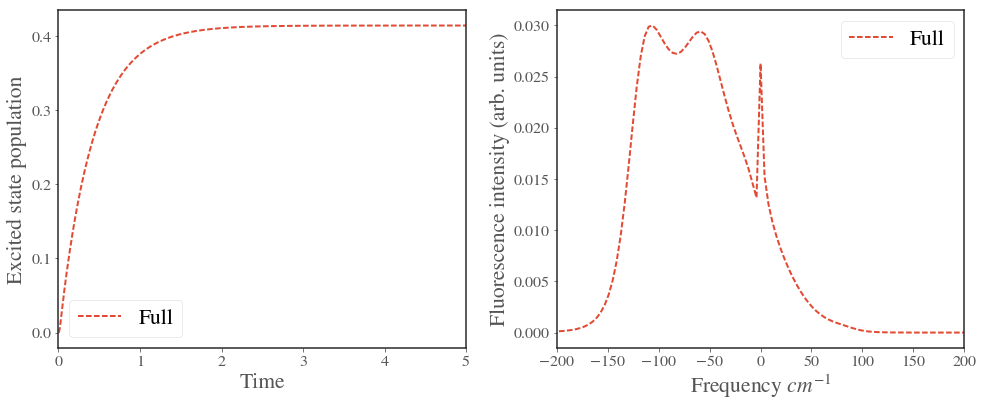

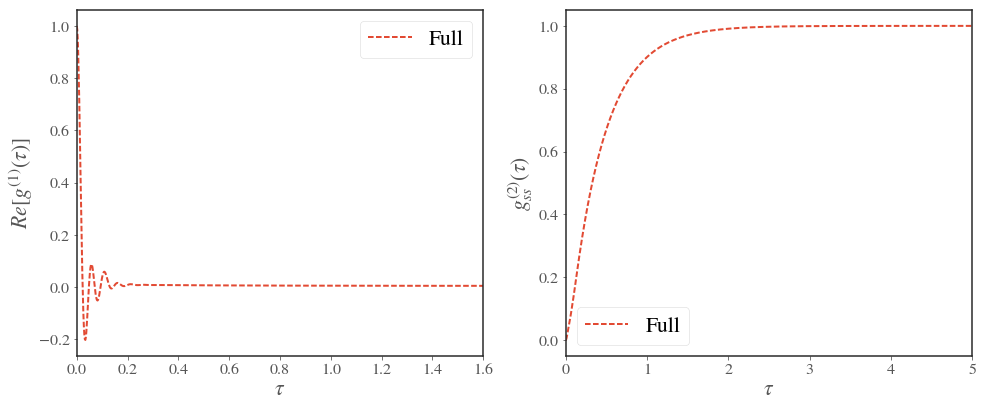

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.392028093338  seconds to build the Non-secular RWA Liouvillian
It took  0.159779071808  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.61467314+0.j         -0.02868934+0.03563651j]
 [-0.02868934-0.03563651j  0.38532686+0.j        ]]
Completed initial dynamics calculations for Full in 1.97718501091  seconds.
Completed correlation function calculations for Full in 1.45442509651 seconds.
G2 took 0.639 seconds
All spectra calculated.


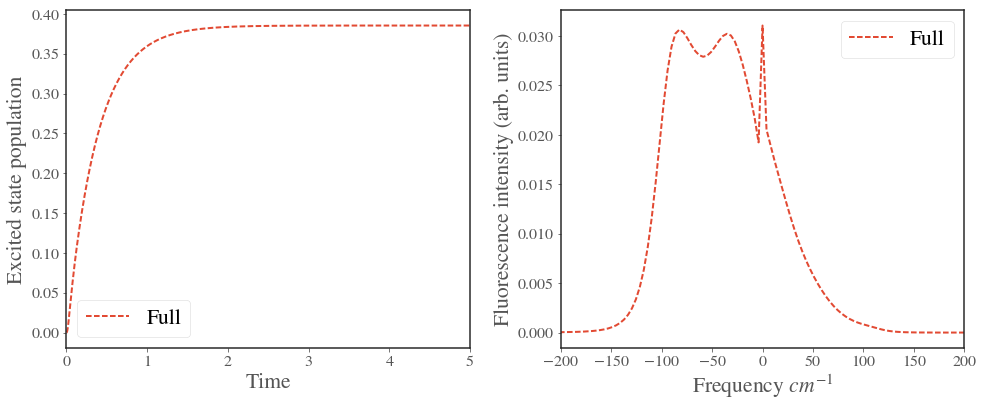

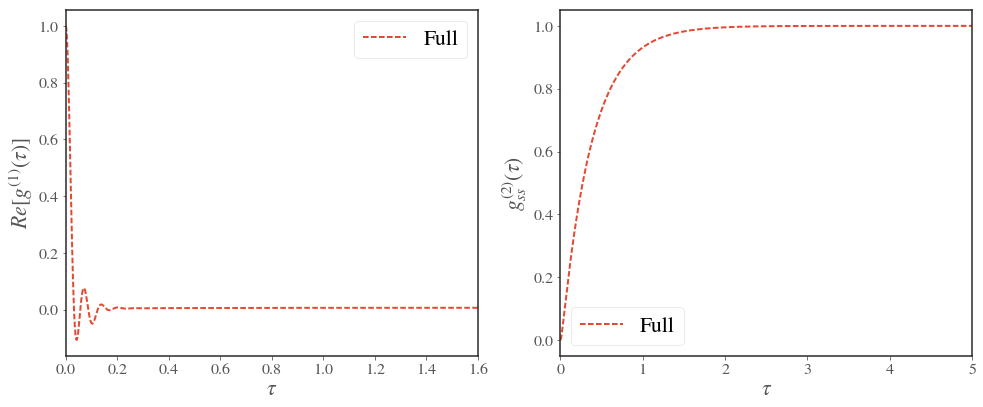

In [17]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=88.62 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.342031002045  seconds to build the Non-secular RWA Liouvillian
It took  0.14689707756  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.69953268+0.j         -0.02400550+0.02219957j]
 [-0.02400550-0.02219957j  0.30046732+0.j        ]]
Completed initial dynamics calculations for Full in 1.3548989296  seconds.
Completed correlation function calculations for Full in 1.02855300903 seconds.
G2 took 0.435 seconds
Steadystate: 
[[ 0.74837658+0.j         -0.02308875+0.02512973j]
 [-0.02308875-0.02512973j  0.25162342+0.j        ]]
Completed initial dynamics calculations for Naive in 1.24825501442  seconds.
Completed correlation function calculations for Naive in 0.997797966003 seconds.
G2 took 0.402 seconds
All spectra calculated.


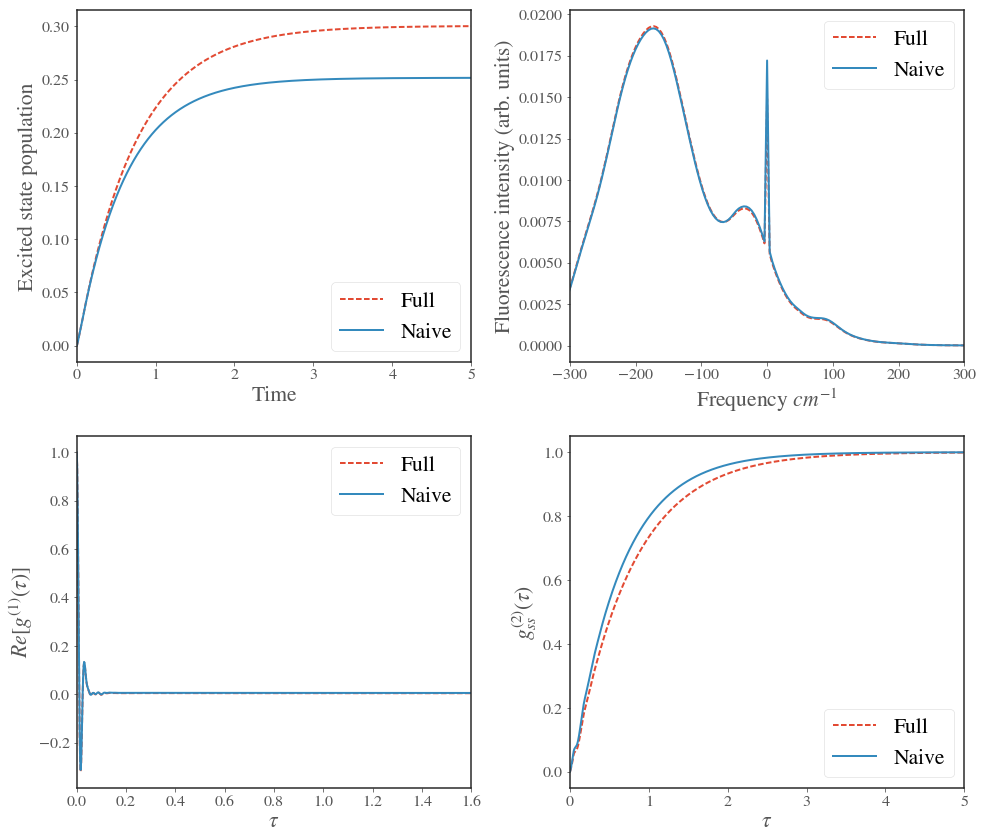

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.357110023499  seconds to build the Non-secular RWA Liouvillian
It took  0.258063077927  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63044496+0.j         -0.02205323+0.03039839j]
 [-0.02205323-0.03039839j  0.36955504+0.j        ]]
Completed initial dynamics calculations for Full in 1.3102889061  seconds.
Completed correlation function calculations for Full in 0.990728139877 seconds.
G2 took 0.507 seconds
Steadystate: 
[[ 0.66506664+0.j         -0.02074700+0.03346534j]
 [-0.02074700-0.03346534j  0.33493336+0.j        ]]
Completed initial dynamics calculations for Naive in 1.4328379631  seconds.
Completed correlation function calculations for Naive in 1.36368703842 seconds.
G2 took 0.634 seconds
All spectra calculated.


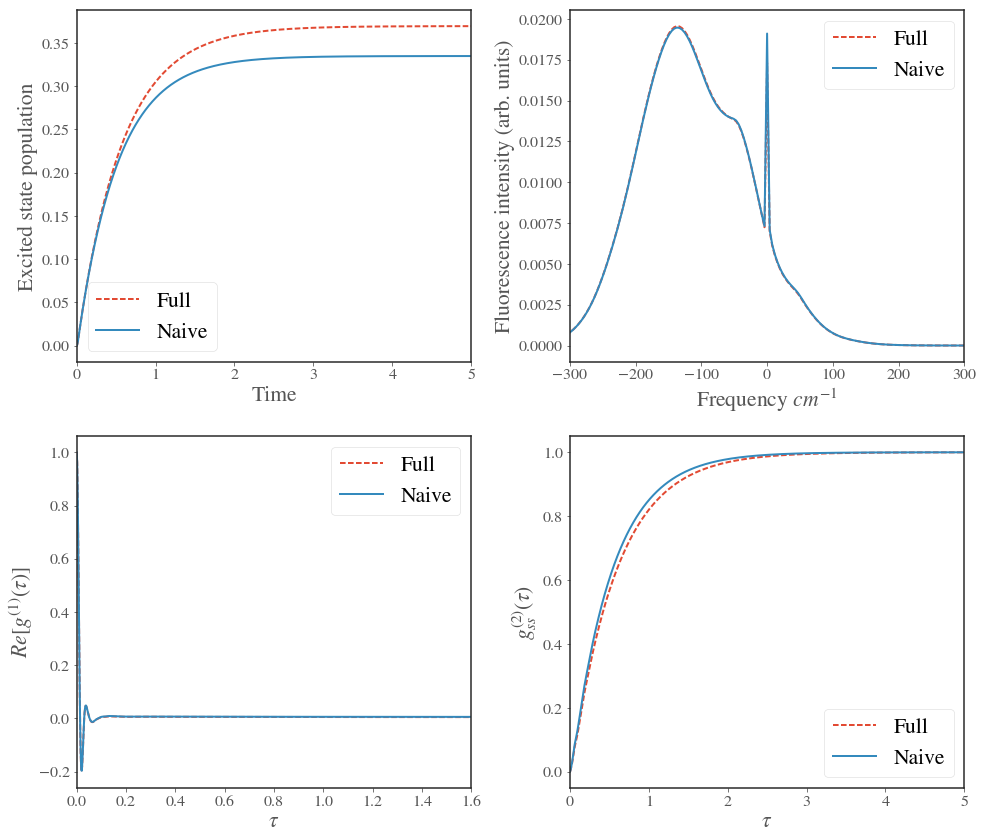

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.511677026749  seconds to build the Non-secular RWA Liouvillian
It took  0.21096777916  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.76103196+0.j         -0.02420863+0.02131021j]
 [-0.02420863-0.02131021j  0.23896804+0.j        ]]
Completed initial dynamics calculations for Full in 1.97814893723  seconds.
Completed correlation function calculations for Full in 1.18476009369 seconds.
G2 took 0.995 seconds
Steadystate: 
[[ 0.77622078+0.j         -0.02362708+0.02234414j]
 [-0.02362708-0.02234414j  0.22377922+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9888920784  seconds.
Completed correlation function calculations for Naive in 1.60914683342 seconds.
G2 took 0.722 seconds
All spectra calculated.


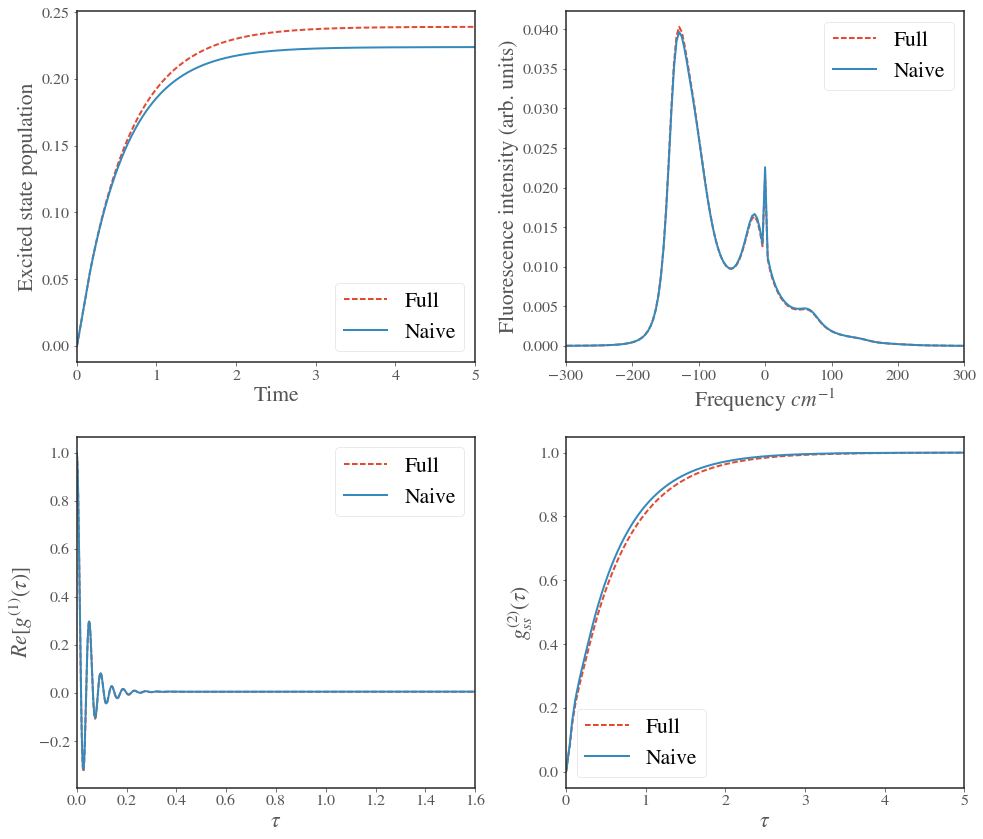

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=44.31 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.386615037918  seconds to build the Non-secular RWA Liouvillian
It took  0.208146095276  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.67149798+0.j        -0.02819039+0.0296174j]
 [-0.02819039-0.0296174j  0.32850202+0.j       ]]
Completed initial dynamics calculations for Full in 1.82608699799  seconds.
Completed correlation function calculations for Full in 1.4369161129 seconds.
G2 took 0.777 seconds
Steadystate: 
[[ 0.68888214+0.j         -0.02760870+0.03107291j]
 [-0.02760870-0.03107291j  0.31111786+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9361550808  seconds.
Completed correlation function calculations for Naive in 1.19508218765 seconds.
G2 took 0.820 seconds
All spectra calculated.


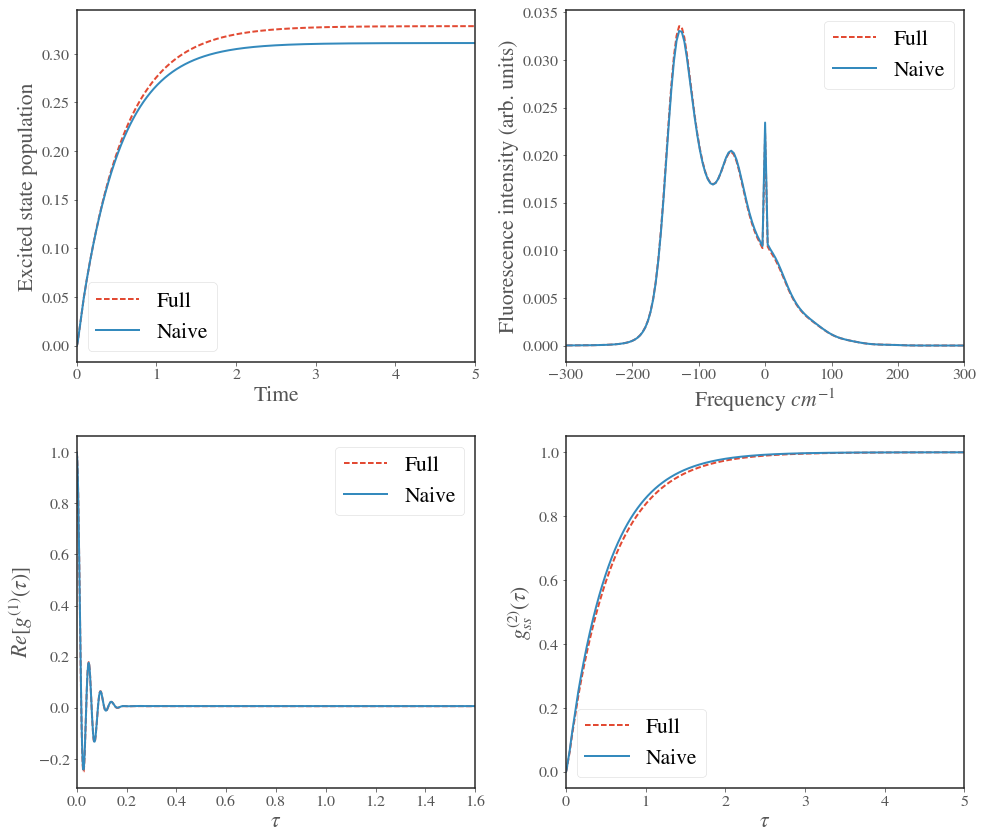

In [29]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.392041921616  seconds to build the Non-secular RWA Liouvillian
It took  0.149307966232  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59528629+0.j          0.01303181+0.03872117j]
 [ 0.01303181-0.03872117j  0.40471371+0.j        ]]
Completed initial dynamics calculations for Full in 1.3572101593  seconds.
Completed correlation function calculations for Full in 0.952977895737 seconds.
G2 took 0.393 seconds
Steadystate: 
[[ 0.60296238+0.j          0.01433440+0.03973069j]
 [ 0.01433440-0.03973069j  0.39703762+0.j        ]]
Completed initial dynamics calculations for Naive in 1.16486597061  seconds.
Completed correlation function calculations for Naive in 0.922996997833 seconds.
G2 took 0.311 seconds
All spectra calculated.


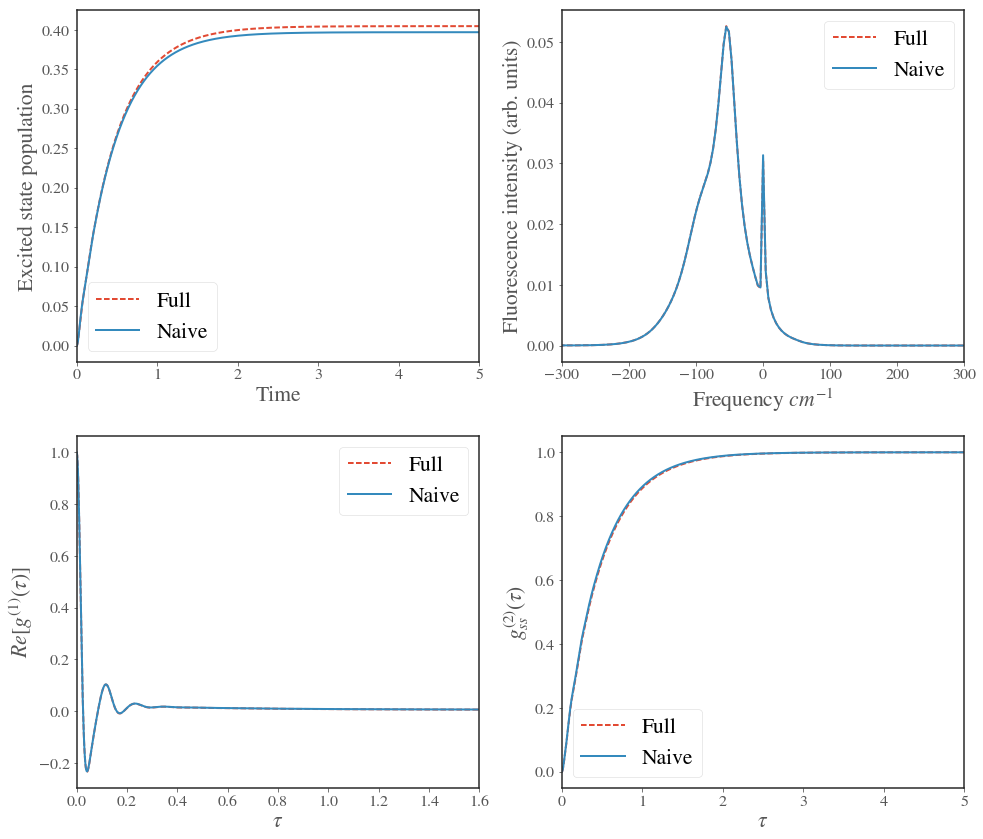

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.355205059052  seconds to build the Non-secular RWA Liouvillian
It took  0.349143981934  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.65930671+0.j          0.03557707+0.03338683j]
 [ 0.03557707-0.03338683j  0.34069329+0.j        ]]
Completed initial dynamics calculations for Full in 1.31622600555  seconds.
Completed correlation function calculations for Full in 1.14694905281 seconds.
G2 took 0.410 seconds
Steadystate: 
[[ 0.66304104+0.j          0.03638318+0.03375614j]
 [ 0.03638318-0.03375614j  0.33695896+0.j        ]]
Completed initial dynamics calculations for Naive in 1.07454609871  seconds.
Completed correlation function calculations for Naive in 0.898280143738 seconds.
G2 took 0.283 seconds
All spectra calculated.


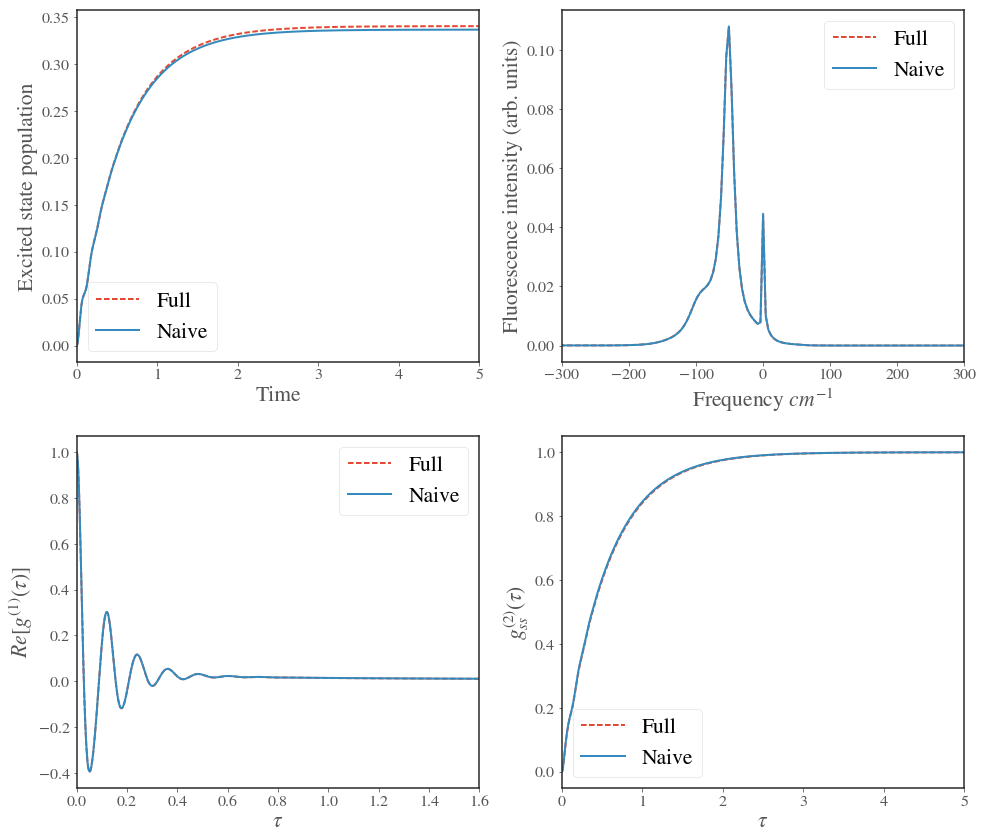

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.338986873627  seconds to build the Non-secular RWA Liouvillian
It took  0.152198076248  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59747071+0.j          0.01525680+0.03932953j]
 [ 0.01525680-0.03932953j  0.40252929+0.j        ]]
Completed initial dynamics calculations for Full in 1.73083615303  seconds.
Completed correlation function calculations for Full in 0.98946595192 seconds.
G2 took 0.951 seconds
Steadystate: 
[[ 0.60250312+0.j          0.01613961+0.03977941j]
 [ 0.01613961-0.03977941j  0.39749688+0.j        ]]
Completed initial dynamics calculations for Naive in 2.04945206642  seconds.
Completed correlation function calculations for Naive in 1.03842902184 seconds.
G2 took 0.819 seconds
All spectra calculated.


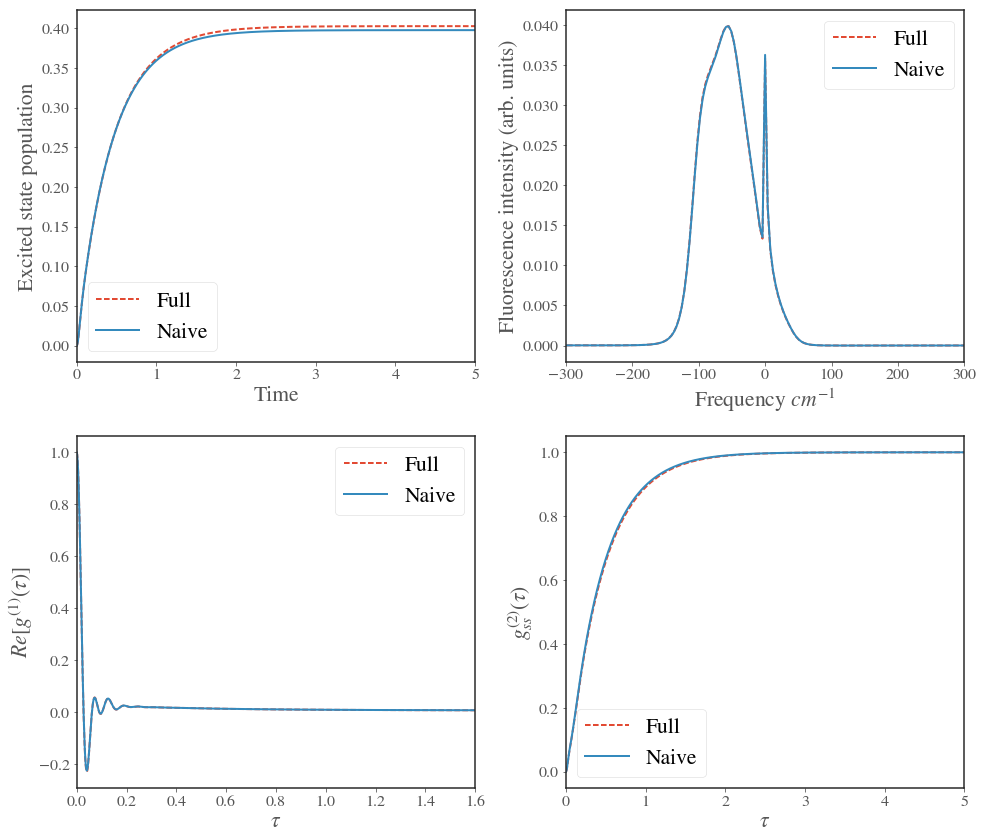

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=14.01 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.341111183167  seconds to build the Non-secular RWA Liouvillian
It took  0.146584033966  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.68116812+0.j          0.05188392+0.03175018j]
 [ 0.05188392-0.03175018j  0.31883188+0.j        ]]
Completed initial dynamics calculations for Full in 1.36547613144  seconds.
Completed correlation function calculations for Full in 0.97603392601 seconds.
G2 took 0.589 seconds
Steadystate: 
[[ 0.68302059+0.j          0.05229715+0.03178252j]
 [ 0.05229715-0.03178252j  0.31697941+0.j        ]]
Completed initial dynamics calculations for Naive in 1.55240893364  seconds.
Completed correlation function calculations for Naive in 1.0134370327 seconds.
G2 took 0.589 seconds
All spectra calculated.


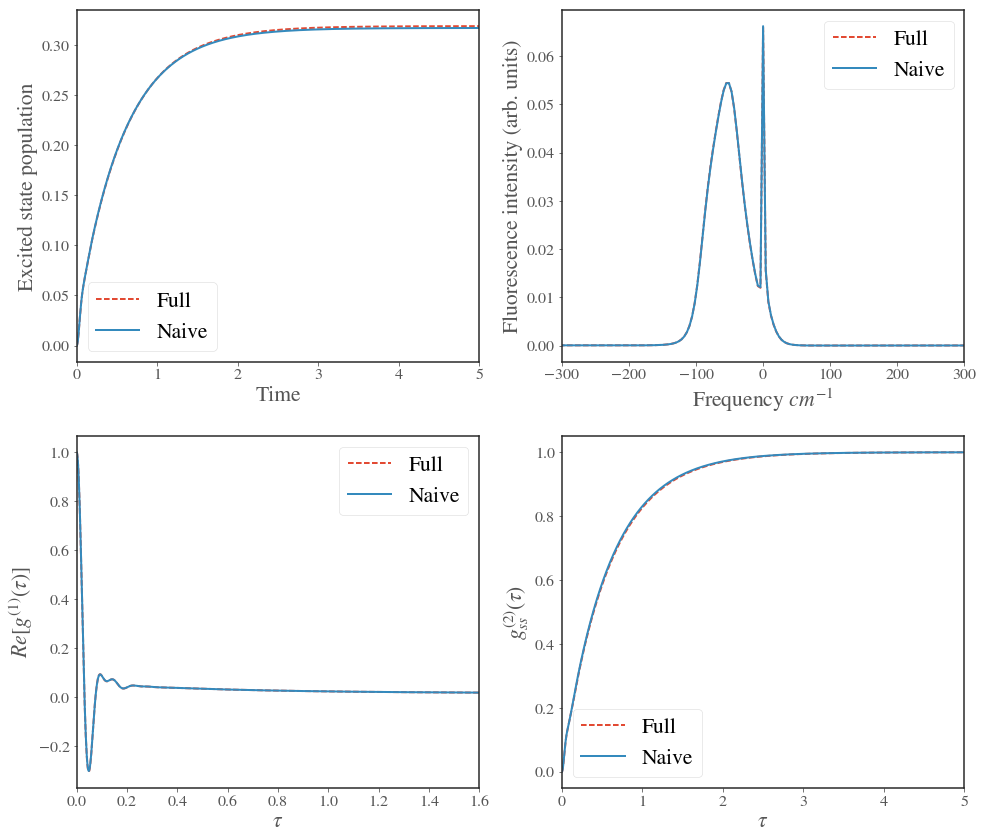

In [30]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)